# here is the part that try to make 3 channel image into 3 tracks midi

In [ ]:
import glob
import os
from pypianoroll import *
import numpy as np
from pypianoroll import Multitrack, Track
from matplotlib import pyplot as plt
import scipy.misc

In [ ]:
beat_resolution = Main_multi_trk.beat_resolution
def get_empty_rate(trck):
    return pypianoroll.metrics.empty_beat_rate(trck.pianoroll,beat_resolution)
def test_create_modify_midi(Main_multi_trk,merge = False):
    drum_trk = []
    piano_trk = []
    base_trk = []
    backup_trk = []
    result_trk = Multitrack()
    for trk in Main_multi_trk.tracks:
        if trk.is_drum:
            drum_trk.append(trk)
        if trk.program  in range(1,9):
            piano_trk.append(trk)
        if trk.program  in range(33,41):
            base_trk.append(trk)
#         else:
#             backup_trk.append(trk)
#     print(backup_trk)
    if len(drum_trk)!=0 :
#         print('drum trk number',len(drum_trk))
        sorted_drum_trk = sorted(drum_trk, key= lambda x: get_empty_rate(x))
#         print(sorted_drum_trk[0].type)
        tmp_trk = merge_trk(sorted_drum_trk,True)
        result_trk.append_track(tmp_trk)
#         print(result_trk.get_empty_tracks())
    if piano_trk :
#         print('piano trk number',len(piano_trk))
        sorted_piano_trk = sorted(piano_trk, key= lambda x: get_empty_rate(x))
#         print('ori',np.sum(sorted_piano_trk[0].pianoroll))
        tmp_trk = merge_trk(sorted_piano_trk,True)
#         print('merge',np.sum(tmp_trk.pianoroll))
        result_trk.append_track(tmp_trk)
#         print(result_trk)
    if base_trk:
#         print('piano trk number',len(piano_trk))
        sorted_base_trk = sorted(base_trk, key= lambda x: get_empty_rate(x))
        tmp_trk = merge_trk(sorted_base_trk,True)
        result_trk.append_track(tmp_trk)
    result_trk.remove_empty_tracks()
    return result_trk





In [ ]:
artist_list = glob.glob('clean_midi/*')
for art in artist_list:
    art_songs = glob.glob(art+'/*.mid')
    for song in art_songs:
        try:
            main_trk = Multitrack(song)
            modi_trk =  create_modify_midi(main_trk)
            if len(modi_trk.tracks) <3:
                continue
            modi_trk.write('3track/'+os.path.basename(song))
        except:
            continue
    

# create 3-channel img from modified midi

In [ ]:
def midi_img(midi_dir,output_dir,repetition,downsample_rate=1):
    midi_list = glob.glob(midi_dir)
    print('total number of midi',len(midi_list))
    cnt = 0
    for song in midi_list:
        if cnt% (0.1* len(midi_list))==0:
            print('processed songs:',cnt)
        song_img = _midi_img(song,repetition,downsample_rate)
        if len(song_img) ==0:
            print('empty song')
            continue
        else :
            img_id =0
            song_base = os.path.basename(song)
            for img in song_img:
                scipy.misc.imsave(output_dir+song_base+'_'+str(img_id)+'.png', img)
                img_id +=1
        cnt+=1
def _midi_img(input_midi,repetition,downsample_rate):
    try:
        song = Multitrack(input_midi)
        song.downsample(downsample_rate)
    #check num of tracks:
        song.remove_empty_tracks()
        if len(song.tracks) != 3:
            print('not 3 tracks midi')
            return []
        else:
            song_len = song.tracks[0].pianoroll.shape[0]
            if song_len<96:
                print('tracks too short ',song_len)
                return []
            for trk in song.tracks:
                if trk.is_drum:
                    drum_roll = trk.pianoroll
                if trk.program in range(1,9):
                    piano_roll = trk.pianoroll
                if trk.program in range(33,41):
                    base_roll = trk.pianoroll
            #then binarize the value
            drum_roll[drum_roll> 0 ]=255
            piano_roll[piano_roll> 0 ]=255
            base_roll[base_roll> 0 ]=255
#             print(piano_roll.shape)
            image_list = []
#             print(min(song_len // 96,repetition) )
            for i in range(min(song_len // 96,repetition)):
                
                temp_img = np.dstack((drum_roll[i*96:96*(1+i),:],piano_roll[i*96:96*(1+i),:],base_roll[i*96:96*(1+i),:]))
                
                image_list.append(temp_img)
                
    except IndexError :
        print('what')
        return [] 
    return image_list
                
                

In [ ]:
midi_dir = 'merge_3track/*.mid'
output_dir = 'down_sample_merge_img/'
repetition = 30
midi_img(midi_dir,output_dir,repetition,downsample_rate=2)

# recover the midi file from image

In [ ]:
img_list = glob.glob('test_data/*')
sorted(img_list)
img_set = []
for img in img_list:
    temp = scipy.misc.imread(img)
    print(temp.shape)
    
#     temp = np.transpose(temp,(1,0,2))
#     temp = cv2.resize(temp,(96,128))
#     temp = cv2.flip(temp,0)
    print(temp.shape)
    img_set.append(temp)
dd = np.hstack(img_set)
scipy.misc.imsave('haha-13.png',dd)

cc = scipy.misc.imread('haha-13.png')# cc = np.transpose(bbb,axes = (1,0,2))
cc[cc<255/(4)] =0
tst_trk = Multitrack()
tr1 = pypianoroll.Track(np.transpose(cc[:,:,0]),program=0, is_drum=True,name='drum')
tr2 = pypianoroll.Track(np.transpose(filter_max(cc[:,:,1])),program=1, is_drum=False,name='piano')
tr3 = pypianoroll.Track(np.transpose(filter_max(cc[:,:,2])),program=33, is_drum=False,name='base')
tst_trk.append_track(tr1)
tst_trk.append_track(tr2)
tst_trk.append_track(tr3)
tst_trk.remove_empty_tracks()
tst_trk.beat_resolution = 12
tst_trk.write('200_filter_outfile.mid')

# below are other packages code that I tried to process the MIDI(Deprecated)

In [1]:
from mido import MidiFile
from midi2audio import FluidSynth

In [6]:
FluidSynth().play_midi('BlueStone_LastDungeon.mid')

In [7]:
fs = FluidSynth()
fs.midi_to_audio('BlueStone_LastDungeon.mid', 'output.wav')


In [8]:
fs.midi_to_audio('BlueStone_LastDungeon.mid', 'output.flac')

In [9]:


mid = MidiFile('BlueStone_LastDungeon.mid', clip=True)
print(mid)

<midi file 'BlueStone_LastDungeon.mid' type 1, 3 tracks, 2500 messages>


In [10]:
for track in mid.tracks:
    print(track)

<midi track 'Last Dungeon' 6 messages>
<midi track 'Right Hand' 1487 messages>
<midi track 'Left Hand' 1007 messages>


In [11]:
for msg in mid.tracks[1]:
    print(msg)

<meta message midi_port port=0 time=0>
<meta message track_name name='Right Hand' time=0>
program_change channel=0 program=0 time=0
control_change channel=0 control=7 value=127 time=0
control_change channel=0 control=10 value=64 time=0
program_change channel=0 program=0 time=0
control_change channel=0 control=7 value=127 time=0
control_change channel=0 control=10 value=64 time=0
note_on channel=0 note=61 velocity=110 time=0
note_on channel=0 note=64 velocity=110 time=0
note_on channel=0 note=69 velocity=110 time=0
note_on channel=0 note=61 velocity=0 time=1488
note_on channel=0 note=64 velocity=0 time=0
note_on channel=0 note=69 velocity=0 time=0
note_on channel=0 note=62 velocity=110 time=48
note_on channel=0 note=65 velocity=110 time=0
note_on channel=0 note=70 velocity=110 time=0
note_on channel=0 note=62 velocity=0 time=1488
note_on channel=0 note=65 velocity=0 time=0
note_on channel=0 note=70 velocity=0 time=0
note_on channel=0 note=63 velocity=110 time=48
note_on channel=0 note=6

In [29]:
music_dir = glob.glob('lmd_matched/A/A/A/TRAAAGR128F425B14B/*.mid')

In [30]:
len(music_dir)

4

In [ ]:
for mid_file in music_dir:
    

In [33]:
file = music_dir[0]
read_file = MidiFile(file,clip = True)
print(read_file.tracks)


[<midi track '' 3 messages>, <midi track 'main synth          ' 1284 messages>, <midi track 'echo synth          ' 260 messages>, <midi track 'main strings h      ' 222 messages>, <midi track 'main strings m      ' 222 messages>, <midi track 'main strings l      ' 222 messages>, <midi track 'main bass           ' 924 messages>, <midi track 'drums + fills       ' 5076 messages>, <midi track 'xtras               ' 484 messages>, <midi track 'harpsichord         ' 508 messages>, <midi track 'verse vibe h        ' 324 messages>, <midi track 'verse vibe m        ' 324 messages>, <midi track 'verse vibe l        ' 324 messages>, <midi track 'verse piano         ' 164 messages>, <midi track 'verse xtra          ' 1156 messages>, <midi track 'end string h        ' 8 messages>, <midi track 'voice               ' 386 messages>, <midi track 'orchestra hit       ' 148 messages>]


In [43]:
file = music_dir[2]
read_file1 = MidiFile(file,clip = True)


In [45]:
read_file1.tracks

[<midi track '' 2 messages>,
 <midi track '' 9 messages>,
 <midi track '1' 16449 messages>,
 <midi track '4' 1005 messages>,
 <midi track '3' 1313 messages>,
 <midi track '10' 4399 messages>,
 <midi track '2' 9955 messages>,
 <midi track '5' 501 messages>,
 <midi track '7' 626 messages>,
 <midi track '8' 283 messages>,
 <midi track '9' 3835 messages>]

In [38]:
del read_file.tracks[1]
read_file.tracks

[<midi track '' 3 messages>,
 <midi track 'echo synth          ' 260 messages>,
 <midi track 'main strings h      ' 222 messages>,
 <midi track 'main strings m      ' 222 messages>,
 <midi track 'main strings l      ' 222 messages>,
 <midi track 'main bass           ' 924 messages>,
 <midi track 'drums + fills       ' 5076 messages>,
 <midi track 'xtras               ' 484 messages>,
 <midi track 'harpsichord         ' 508 messages>,
 <midi track 'verse vibe h        ' 324 messages>,
 <midi track 'verse vibe m        ' 324 messages>,
 <midi track 'verse vibe l        ' 324 messages>,
 <midi track 'verse piano         ' 164 messages>,
 <midi track 'verse xtra          ' 1156 messages>,
 <midi track 'end string h        ' 8 messages>,
 <midi track 'voice               ' 386 messages>,
 <midi track 'orchestra hit       ' 148 messages>]

In [39]:
read_file1.tracks
read_file.tracks.append(read_file1.tracks[2])

In [20]:
for msg in read_file.tracks[0]:
    print(msg)
    break

<meta message time_signature numerator=4 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=0>


In [22]:
for trck in read_file.tracks:
    print(trck)

<midi track '' 3 messages>
<midi track 'Soft Karaoke' 7 messages>
<midi track 'Words' 297 messages>
<midi track 'Upper Chord' 659 messages>
<midi track 'Lower Chord' 293 messages>
<midi track 'Guitar 1' 415 messages>
<midi track 'Mark' 587 messages>
<midi track 'Lower Chord' 293 messages>
<midi track 'Guitar 1' 415 messages>
<midi track 'More Low Stuff' 293 messages>
<midi track 'Drums' 4567 messages>
<midi track 'Vocoder' 147 messages>


In [40]:
read_file.save('ttest.mid')

In [41]:
revers = MidiFile('ttest.mid',clip =True)

In [56]:
revers.tracks[1].reverse()

In [57]:
revers.save('re.mid')

In [61]:
j = 0
for i in revers.tracks[1]:
    j+=1
    if j ==10:
        break
    print(i)

<meta message end_of_track time=0>
note_off channel=1 note=71 velocity=80 time=47
note_on channel=1 note=71 velocity=80 time=14
note_off channel=1 note=72 velocity=80 time=77
note_on channel=1 note=72 velocity=80 time=40
note_off channel=1 note=74 velocity=80 time=68
note_on channel=1 note=74 velocity=80 time=9
note_off channel=1 note=67 velocity=80 time=73
note_on channel=1 note=67 velocity=80 time=4


In [71]:
a = i.dict()

In [72]:
a

{'channel': 1, 'note': 69, 'time': 74, 'type': 'note_off', 'velocity': 80}

In [74]:
from music21 import converter,instrument

In [76]:
a = MidiFile('deepjazz_on_metheny...25_epochs.mid',clip=True)

In [79]:
a.play()

<generator object MidiFile.play at 0x10ab8e308>

In [80]:
FluidSynth().play_midi('deepjazz_on_metheny...25_epochs.mid')

In [81]:
fs = FluidSynth()
fs.midi_to_audio('deepjazz_on_metheny...25_epochs.mid', 'output.wav')


In [91]:
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
# TOTAL
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
SET_CUDA_AVAIL = -1
SET_CUDA_FALSE = 0
SET_CUDA_TRUE = 1
ACCEPT_USING_CUDA = SET_CUDA_TRUE
GLOBAL_IS_DEBUG = True
GLOBAL_IS_PUBLISHED = False
GLOBAL_IS_CREATE_RAW_MIDI = True
GLOBAL_IS_CREATE_PIANO_MIDI = True
GLOBAL_IS_CREATE_BIT_IMAGE = True
GLOBAL_IS_CREATE_WEIGHT_IMAGE = True

GLOBAL_MODEL_LOAD_NUM_TRAIN = -1
GLOBAL_MODEL_LOAD_NUM_PUBLISHED = -1
GLOBAL_MODEL_LOAD_MODEL_NAME = 'GAN'
GLOBAL_MODEL_LOAD_DIRECTORY_PUBLISHED = 'Published'
GLOBAL_MODEL_LOAD_DIRECTORY_TRAIN = 'MIDI_GAN'
GLOBAL_MODEL_SAVE_DIRECTORY_TRAIN = 'MIDI_GAN'

GLOBAL_EPOCH_NUM = 1000
GLOBAL_EPOCH_GEN_TERM = 10
GLOBAL_EPOCH_SAVE_TERM = 60
GLOBAL_RECORD_STEPS_FOR_LOSS = 32

GLOBAL_DATA_LOAD_BY_CHUNK = True
GLOBAL_DATA_LOAD_NUM = 1024
GLOBAL_BATCH_SIZE = 16
GLOBAL_BATCH_SIZE_FOR_ACCURACY = 8

GLOBAL_LEARNING_RATE = 0.0002
GLOBAL_TRAIN_BALANCE_D_STEPS = 1  # Recommended : don't try to balance
GLOBAL_TRAIN_BALANCE_G_STEPS = 1  # Recommended : don't try to balance

'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
# SETTING
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MIDI_LENGTH = 256
MIDI_LENGTH_UNIT = 512
MIDI_THRESHOLD = 0.6

# note range of mid file : 0~127
# but midi file's notes are distributed at 30 to 90
# generally 30~60 : chord, 50~90 : melody
MIDI_NOTE_NUMBER = 128
MIDI_NOTE_DISTRIBUTION_START = 30
MIDI_NOTE_DISTRIBUTION_END = 94
MIDI_NOTE_DISTRIBUTION = MIDI_NOTE_DISTRIBUTION_END - MIDI_NOTE_DISTRIBUTION_START
DATA_INPUT_PATH = '../ApolloGAN_Database'
DATA_OUTPUT_PATH = './DataOutput'
DATA_LOADER_PATH = 'Data_midiTrain/reels'
DATA_PUBLISHED_PATH = 'ABSOLUTE_PATH_OF_MODEL_DATA'

'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
# DCGAN
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
GAN_BATCH_SIZE = GLOBAL_BATCH_SIZE
GAN_LEARNING_RATE = GLOBAL_LEARNING_RATE
GAN_NOISE_CHANNEL = 7
GAN_NOISE_HEIGHT = 2  # Don't mind ( fixed value because of model )
GAN_NOISE_WIDTH = 8  # Don't mind ( fixed value because of model )
GAN_INPUT_WIDTH = MIDI_LENGTH
GAN_INPUT_HEIGHT = MIDI_NOTE_DISTRIBUTION
GAN_INPUT_CHANNEL = 1  # (for channel number)
GAN_FILTER_DEPTH = 128
GAN_KERNEL_SIZE = 4
GAN_STRIDE_SIZE = 2
GAN_PADDING_SIZE = 1

In [555]:
# import environments as env
from mido import MetaMessage, Message, MidiFile, MidiTrack

'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
# load
# TrackTimeList = (Track number,   Track Sequence,    pushed sequence time)
# TrackNoteList = (Track number,   Track Sequence,    note, duration for each sequence
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MIDI_NOTE_NUMBER = 128
def load(path):
    checkNoteOn         = [0 for i in range(MIDI_NOTE_NUMBER)]
    recordNoteStartTime = [0 for i in range(MIDI_NOTE_NUMBER)]
    midiFile            = MidiFile(path)
    TrackTimeList       = []
    TrackNoteList       = []

    for i, track in enumerate(midiFile.tracks):
        msgList = []
        msgTime = 0
        for message in track:

            msgTime += message.time
            if message.type == 'note_on':
                cur_note = message.bytes()[1]
                velocity = message.bytes()[2]
                if cur_note != 0:
                    if velocity != 0:
                        checkNoteOn[cur_note] = 1
                        recordNoteStartTime[cur_note] = msgTime
                    elif checkNoteOn[cur_note] == 1:
                        # if velocity == 0, use like note_off
                        checkNoteOn[cur_note] = 0
                        curNoteDuration = (msgTime) - recordNoteStartTime[cur_note]
                        msgList.append([cur_note, recordNoteStartTime[cur_note], curNoteDuration])

            if message.type == 'note_off':
                cur_note = message.bytes()[1]
                if cur_note != 0 and checkNoteOn[cur_note] == 1:
                    checkNoteOn[cur_note] = 0
                    curNoteDuration = (msgTime) - recordNoteStartTime[cur_note]
                    msgList.append([cur_note, recordNoteStartTime[cur_note], curNoteDuration])

        if len(msgList) <= 1:
            continue

        # sort by when note_on is loaded
        def cmpKey(elements):
            return elements[1]
        msgList.sort(key=cmpKey)
        timeBefore = -1
        noteAtTime = []
        noteList = []
        timeList = [0]
        for note, startTime, durationTime in msgList:
            if timeBefore == startTime or startTime == 0:
                # noteAtTime(notes which should be pressed at this timing)
                noteAtTime.append([note, durationTime])
            else:
                noteList.append(noteAtTime)
                noteAtTime = []
                noteAtTime.append([note, durationTime])
                timeList.append(startTime)
                timeBefore = startTime

        # append final note to noteList because it only saved in noteAtTime
        noteList.append(noteAtTime)

        TrackTimeList.append(timeList)
        TrackNoteList.append(noteList)
    return TrackTimeList, TrackNoteList





'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
# save
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
def save(path, timeList, noteList, metaData=[250000, 'A']):
    def cmpKey(elements):
        return elements[1]
    checkNoteOn       = [0 for i in range(MIDI_NOTE_NUMBER)]
    recordNoteOffTime = [-1 for i in range(MIDI_NOTE_NUMBER)]
    output_mid = MidiFile()
    track_meta = MidiTrack()
    track_meta.append(MetaMessage('set_tempo', tempo=metaData[0], time=0))
    track_meta.append(MetaMessage('key_signature', key=metaData[1], time=0))
    output_mid.tracks.append(track_meta)

    track_num = len(timeList)
    for i_track in range(track_num):
        track = MidiTrack()
        output_mid.tracks.append(track)
        track.append(Message('program_change', program=12, time=0))
        i_time_before = 0

        # Add enough time 10000 for ending final note off
        finalNote_index = len(timeList[i_track])-1
        if finalNote_index < 0:
            # When note not exist
            break
        finalNote_time = timeList[i_track][finalNote_index]
        finalNote_duration = max(noteList[i_track][finalNote_index], key=cmpKey)[1]+1000

        timeList[i_track].append(finalNote_time + finalNote_duration)
        noteList[i_track].append([[0 ,0]])
        for index, i_time in enumerate(timeList[i_track]):
            # searching note which should be noted off from previous time to next time and add it to list
            NoteOffBetweenTimeGapList = []
            for NoteIndex, NoteOffTime in enumerate(recordNoteOffTime):
                if (i_time_before <= NoteOffTime) & (NoteOffTime <= i_time) & (NoteOffTime != -1):
                    NoteOffBetweenTimeGapList.append([NoteIndex, NoteOffTime])

            # plan : sorting list and note off starting at lowest number
            NoteOffBetweenTimeGapList.sort(key=cmpKey)
            for note, NoteOffBetweenTimeGap in NoteOffBetweenTimeGapList:
                track.append(Message('note_off', note=note, velocity=127, time=NoteOffBetweenTimeGap-i_time_before))
                i_time_before = NoteOffBetweenTimeGap
                checkNoteOn[note] = 0

            # for addiing empty time
            if index != 0:
                track.append(Message('note_on', note=0, velocity=0, time=i_time-i_time_before))
                track.append(Message('note_off', note=0, velocity=0, time=0))
                recordNoteOffTime[0] = -1
            i_time_before = i_time

            # Note on all note which should be played at this time, and update when it should be ended
            for note, duration in noteList[i_track][index]:
                # If it is already set, note off and immediately note on
                if checkNoteOn[note] == 1:
                    track.append(Message('note_off', note=note, velocity=127, time=0))

                track.append(Message('note_on', note=note, velocity=127, time=0))
                recordNoteOffTime[note] = i_time + duration
                checkNoteOn[note] = 1

    output_mid.save(path)



'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
# sample
# def sample_create_midi
# def sample_using_multihot
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
def sample_create_midi(path):
    track1_TimeList =  [0, 960, 1920, 2880]
    track1_NoteList =  [
                            [
                                [62, 960],
                                [66, 960]
                            ],
                            [
                                [64, 960],
                                [68, 960]
                            ],
                            [
                                [66, 960],
                                [70, 960]
                            ],
                            [
                                [68, 960],
                                [72, 960]
                            ]
                        ]

    timeList = []
    noteList = []
    timeList.append(track1_TimeList)
    noteList.append(track1_NoteList)
    save(path, timeList, noteList)



def sample_main():
#     sample_create_midi('../{}/Data_TestSet/Sample.mid'.format(env.DATA_INPUT_PATH))
    sample_create_midi('./Sample.mid')

In [181]:
# import Util.MidiIO as midi
# import environments as env
import numpy as np
import os
from PIL import Image

def getBitArrayFromMidi(srcPath):
    timeListLoaded, noteListLoaded = load(srcPath)
    bitArray = np.zeros((MIDI_NOTE_DISTRIBUTION, MIDI_LENGTH)).astype('uint8')
    for trackCnt in range(len(timeListLoaded)):
        for timeCnt, time in enumerate(timeListLoaded[trackCnt]):
            imageX = int(time / MIDI_LENGTH_UNIT)
            for noteCnt in range(len(noteListLoaded[trackCnt][timeCnt])):
                note = noteListLoaded[trackCnt][timeCnt][noteCnt][0]
                duration = noteListLoaded[trackCnt][timeCnt][noteCnt][1]
                imageY = min(note - MIDI_NOTE_DISTRIBUTION_START,63)
#                 print(imageY)
                length = int(duration / MIDI_LENGTH_UNIT)
                for offset in range(length):
                    if imageX + offset >= MIDI_LENGTH:
                        break
                    bitArray[imageY][imageX + offset] = 1
    return bitArray



def getImgArrayFromBitArray(bitArray):
    imgArray = np.zeros((MIDI_NOTE_DISTRIBUTION, MIDI_LENGTH, 3)).astype('uint8')
    for i in range(MIDI_NOTE_DISTRIBUTION):
        for j in range(MIDI_LENGTH):
            if bitArray[i][j] >= MIDI_THRESHOLD:
                imgArray[i][j][0] = 255
                imgArray[i][j][1] = 255
                imgArray[i][j][2] = 255
    return imgArray



def getImageFromBitArray(bitArray, dstPath):
    imgArray = getImgArrayFromBitArray(bitArray)
    image = Image.fromarray(imgArray).convert('RGB')
    image.save(dstPath)



def getImageFromMidi(srcPath, dstPath):
    bitArray = getBitArrayFromMidi(srcPath)
    imgArray = getImgArrayFromBitArray(bitArray)
    image = Image.fromarray(imgArray).convert('RGB')
    image.save(dstPath)



def getImageFromWeight(weightArray, dstPath):
    imgArray = np.zeros((MIDI_NOTE_DISTRIBUTION, MIDI_LENGTH, 3)).astype('uint8')
    for i in range(MIDI_NOTE_DISTRIBUTION):
        for j in range(MIDI_LENGTH):
            imgArray[i][j][0] = int(255 * weightArray[i][j])
            imgArray[i][j][1] = int(255 * weightArray[i][j])
            imgArray[i][j][2] = int(255 * weightArray[i][j])
    image = Image.fromarray(imgArray).convert('RGB')
    image.save(dstPath)



def getMidiFromBitArray(bitArray, dstPath):
    timeList = []
    noteList = []
    noteOn = [-1 for i in range(MIDI_NOTE_DISTRIBUTION)]
    noteOnTime = [-1 for i in range(MIDI_NOTE_DISTRIBUTION)]
    noteIndex = 0

    for j in range(MIDI_LENGTH):
        currentTimingNote = []
        for i in range(MIDI_NOTE_DISTRIBUTION):
            if bitArray[i][j] >= MIDI_THRESHOLD:
                if noteOn[i] == -1:
                    # When find out note which should be pressed at this timing
                    noteOn[i] = noteIndex
                    noteOnTime[i] = j * MIDI_LENGTH_UNIT
                    
                    # If there is no note at this timing, appendding it
                    if len(currentTimingNote) == 0:
                        timeList.append(j * MIDI_LENGTH_UNIT)
                        
                    # Append it to list which is saving pressed note at this timing
                    currentTimingNote.append([i, MIDI_LENGTH_UNIT])
            else:
                if noteOn[i] != -1:
                    refNum = noteOn[i]
                    for note in noteList[refNum]:
                        if note[0] == i:
                            note[1] = j * MIDI_LENGTH_UNIT - noteOnTime[i]
                            break
                    noteOn[i] = -1
        if len(currentTimingNote) > 0:
            noteList.append(currentTimingNote)
            noteIndex += 1

    for i in range(len(noteList)):
        for j in range(len(noteList[i])):
            noteList[i][j][0] += MIDI_NOTE_DISTRIBUTION_START

    save(dstPath, [timeList], [noteList])



def getBitArrayFromHotArray(hotArray):
    bitArray = np.zeros((MIDI_NOTE_DISTRIBUTION, MIDI_LENGTH)).astype('uint8')
    for i in range(MIDI_NOTE_DISTRIBUTION):
        for j in range(MIDI_LENGTH):
            if hotArray[j][i] >= MIDI_THRESHOLD:
                bitArray[i][j] = 1
    return bitArray



def getHotArrayFromBitArray(bitArray):
    hotArray = []
    for j in range(MIDI_LENGTH):
        hotVector = [0 for i in range(MIDI_NOTE_DISTRIBUTION)]
        for i in range(MIDI_NOTE_DISTRIBUTION):
            if bitArray[i][j] >= MIDI_THRESHOLD:
                hotVector[i] = 1
        hotArray.append(hotVector)
    return np.array(hotArray)



def cloneBitArray(layback, src):
    dst = np.zeros((MIDI_NOTE_DISTRIBUTION, MIDI_LENGTH)).astype('uint8')
    for i in range(MIDI_NOTE_DISTRIBUTION):
        for j in range(layback, MIDI_LENGTH):
            dst[i][j] = src[i][j-layback]
    return dst


'''
# test code of functions
bitArray = getBitArrayFromMidi('../{}/Data_TestSet/test00.mid'.format(env.DATA_INPUT_PATH))
print(bitArray.shape)
print(bitArray.tolist())
hotArray = getHotArrayFromBitArray(bitArray)
print(hotArray.shape)
print(hotArray.tolist())
bitArray = getBitArrayFromHotArray(hotArray)
print(bitArray.shape)
print(bitArray.tolist())
getMidiFromBitArray(bitArray, '../{}/Data_TestSet/test00rrre.mid'.format(env.DATA_INPUT_PATH))
'''

"\n# test code of functions\nbitArray = getBitArrayFromMidi('../{}/Data_TestSet/test00.mid'.format(env.DATA_INPUT_PATH))\nprint(bitArray.shape)\nprint(bitArray.tolist())\nhotArray = getHotArrayFromBitArray(bitArray)\nprint(hotArray.shape)\nprint(hotArray.tolist())\nbitArray = getBitArrayFromHotArray(hotArray)\nprint(bitArray.shape)\nprint(bitArray.tolist())\ngetMidiFromBitArray(bitArray, '../{}/Data_TestSet/test00rrre.mid'.format(env.DATA_INPUT_PATH))\n"

In [556]:
t_list,n_list = load('deepjazz_on_metheny...25_epochs.mid')

In [563]:
# save('re_deep.mid',t_list,n_list)
srcPath = 'deepjazz_on_metheny...25_epochs.mid'
dstPath ='new_test.png'
getImageFromMidi(srcPath, dstPath)

In [552]:
a = MidiFile('deepjazz_on_metheny...25_epochs.mid',clip=True)

In [101]:
a

<midi file 'deepjazz_on_metheny...25_epochs.mid' type 1, 1 tracks, 1028 messages>

In [103]:
b = MidiFile('re_deep.mid',clip=True)

In [104]:
b

<midi file 're_deep.mid' type 1, 2 tracks, 1715 messages>

In [558]:
bit_arr = getBitArrayFromMidi('jazz/TheImpossibleDream.mid')

In [559]:
bit_arr[50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [560]:
img = getImgArrayFromBitArray(bit_arr)
print(img.shape)

(64, 256, 3)


In [157]:
from PIL import Image
fs = FluidSynth()
fs.midi_to_audio('re_deep.mid', 'output.wav')



In [134]:
image = Image.fromarray(img).convert('RGB')

In [158]:
image.show()

In [ ]:
getMidiFromBitArray(bitArray, 'dstPath.mid'):

In [156]:
np.array(image)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [ ]:
def midifromimage(image):
    

In [160]:
test_mid = MidiFile('Allthethingsyouare.mid')

In [166]:
for i in test_mid.tracks[2]:
    print(i)

<meta message midi_port port=0 time=0>
program_change channel=1 program=35 time=0
control_change channel=1 control=7 value=127 time=0
control_change channel=1 control=11 value=127 time=0
control_change channel=1 control=64 value=0 time=0
control_change channel=1 control=67 value=0 time=0
pitchwheel channel=1 pitch=0 time=0
note_on channel=1 note=45 velocity=63 time=1408
note_on channel=1 note=45 velocity=0 time=64
note_on channel=1 note=44 velocity=43 time=64
note_on channel=1 note=37 velocity=60 time=256
note_on channel=1 note=44 velocity=0 time=8
note_on channel=1 note=45 velocity=54 time=1144
note_on channel=1 note=37 velocity=0 time=32
note_on channel=1 note=45 velocity=0 time=16
note_on channel=1 note=44 velocity=48 time=80
note_on channel=1 note=44 velocity=0 time=240
note_on channel=1 note=37 velocity=62 time=16
note_on channel=1 note=45 velocity=50 time=384
note_on channel=1 note=45 velocity=0 time=56
note_on channel=1 note=37 velocity=0 time=0
note_on channel=1 note=44 velocit

In [171]:
src = 'Allthethingsyouare.mid'
dst = 'piano_Allthethingsyouare.mid'
changeToPiano(src, dst)

In [176]:
converter_file = converter.parse(src)

for part in converter_file.parts:
    print(part)
    break

<music21.stream.Part 0xa24bf2668>


In [177]:
part.

<music21.stream.Part 0xa24bf2668>

In [196]:
# test code of functions
bitArray = getBitArrayFromMidi( 'Allthethingsyouare.mid')
print(bitArray.shape)
# print(bitArray.tolist())
# hotArray = getHotArrayFromBitArray(bitArray)
# print(hotArray.shape)
# # print(hotArray.tolist())
# bitArray = getBitArrayFromHotArray(hotArray)
# print(bitArray.shape)
# print(bitArray.tolist())
getMidiFromBitArray(bitArray,  'Allthethingsyouare_midi.mid')


track num: 0
track num: 1
track num: 2


TypeError: object of type 'int' has no len()

In [195]:
def load(path):
    checkNoteOn         = [0 for i in range(MIDI_NOTE_NUMBER)]
    recordNoteStartTime = [0 for i in range(MIDI_NOTE_NUMBER)]
    midiFile            = MidiFile(path)
    TrackTimeList       = []
    TrackNoteList       = []

    for i, track in enumerate(midiFile.tracks):
        print('track num:',i)
        msgList = []
        msgTime = 0
        for message in track:

            msgTime += message.time
            if message.type == 'note_on':
                cur_note = message.bytes()[1]
                velocity = message.bytes()[2]
                if cur_note != 0:
                    if velocity != 0:
                        checkNoteOn[cur_note] = 1
                        recordNoteStartTime[cur_note] = msgTime
                    elif checkNoteOn[cur_note] == 1:
                        # if velocity == 0, use like note_off
                        checkNoteOn[cur_note] = 0
                        curNoteDuration = (msgTime) - recordNoteStartTime[cur_note]
                        msgList.append([cur_note, recordNoteStartTime[cur_note], curNoteDuration])

            if message.type == 'note_off':
                cur_note = message.bytes()[1]
                if cur_note != 0 and checkNoteOn[cur_note] == 1:
                    checkNoteOn[cur_note] = 0
                    curNoteDuration = (msgTime) - recordNoteStartTime[cur_note]
                    msgList.append([cur_note, recordNoteStartTime[cur_note], curNoteDuration])

        if len(msgList) <= 1:
            continue

        # sort by when note_on is loaded
        def cmpKey(elements):
            return elements[1]
        msgList.sort(key=cmpKey)
        timeBefore = -1
        noteAtTime = []
        noteList = []
        timeList = [0]
        for note, startTime, durationTime in msgList:
            if timeBefore == startTime or startTime == 0:
                # noteAtTime(notes which should be pressed at this timing)
                noteAtTime.append([note, durationTime])
            else:
                noteList.append(noteAtTime)
                noteAtTime = []
                noteAtTime.append([note, durationTime])
                timeList.append(startTime)
                timeBefore = startTime

        # append final note to noteList because it only saved in noteAtTime
        noteList.append(noteAtTime)

        TrackTimeList.append(timeList)
        TrackNoteList.append(noteList)
        print('TrackTimeList',len(TrackTimeList[0]))
    return TrackTimeList, TrackNoteList




In [23]:
from music21 import converter, instrument, note, chord
import json
import sys
import numpy as np
from imageio import imwrite

def extractNote(element):
    return int(element.pitch.ps)

def extractDuration(element):
    return element.duration.quarterLength

def get_notes(notes_to_parse):

    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    durations = []
    notes = []
    start = []

    for element in notes_to_parse:
        if isinstance(element, note.Note):
            if element.isRest:
                continue

            start.append(element.offset)
            notes.append(extractNote(element))
            durations.append(extractDuration(element))
                
        elif isinstance(element, chord.Chord):
            if element.isRest:
                continue
            for chord_note in element.notes:
                start.append(element.offset)
                durations.append(extractDuration(element))
                notes.append(extractNote(chord_note))

    return {"start":start, "pitch":notes, "dur":durations}

def midi2image(midi_path):
    mid = converter.parse(midi_path)

    instruments = instrument.partitionByInstrument(mid)

    data = {}

    try:
        i=0
        for instrument_i in instruments.parts:
            notes_to_parse = instrument_i.recurse()

            if instrument_i.partName is None:
                data["instrument_{}".format(i)] = get_notes(notes_to_parse)
                i+=1
            else:
                data[instrument_i.partName] = get_notes(notes_to_parse)

    except:
        notes_to_parse = mid.flat.notes
        data["instrument_0".format(i)] = get_notes(notes_to_parse)

    resolution = 0.25

    for instrument_name, values in data.items():
        # https://en.wikipedia.org/wiki/Scientific_pitch_notation#Similar_systems
        upperBoundNote = 127
        lowerBoundNote = 21
        maxSongLength = 100

        index = 0
        prev_index = 0
        repetitions = 0
        while repetitions < int(REPETITION):
            if prev_index >= len(values["pitch"]):
                break

            matrix = np.zeros((upperBoundNote-lowerBoundNote,maxSongLength))

            pitchs = values["pitch"]
            durs = values["dur"]
            starts = values["start"]

            for i in range(prev_index,len(pitchs)):
                pitch = pitchs[i]

                dur = int(durs[i]/resolution)
                start = int(starts[i]/resolution)

                if dur+start - index*maxSongLength < maxSongLength:
                    for j in range(start,start+dur):
                        if j - index*maxSongLength >= 0:
                            matrix[pitch-lowerBoundNote,j - index*maxSongLength] = 255
                else:
                    prev_index = i
                    break
#             w_path = midi_path.split("/")[-1].replace(".mid",f"_{instrument_name}_{index}.png")
            w_path = 'jazz_image/'+instrument_name+str(index)+'.png'
            imwrite(w_path,matrix)
            index += 1
            repetitions+=1


In [204]:
REPETITION = 3
midi2image('Allthethingsyouare.mid')

In [205]:
midi2image('Allthethingsyouare.mid')

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


In [202]:
from PIL import Image
import numpy as np
from music21 import instrument, note, chord, stream

lowerBoundNote = 21
def column2notes(column):
    notes = []
    for i in range(len(column)):
        if column[i] > 255/2:
            notes.append(i+lowerBoundNote)
    return notes

resolution = 0.25
def updateNotes(newNotes,prevNotes): 
    res = {} 
    for note in newNotes:
        if note in prevNotes:
            res[note] = prevNotes[note] + resolution
        else:
            res[note] = resolution
    return res

def image2midi(image_path):
    with Image.open(image_path) as image:
        im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)
        try:
            im_arr = im_arr.reshape((image.size[1], image.size[0]))
        except:
            im_arr = im_arr.reshape((image.size[1], image.size[0],3))
            im_arr = np.dot(im_arr, [0.33, 0.33, 0.33])

    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model

    prev_notes = updateNotes(im_arr.T[0,:],{})
    for column in im_arr.T[1:,:]:
        notes = column2notes(column)
        # pattern is a chord
        notes_in_chord = notes
        old_notes = prev_notes.keys()
        for old_note in old_notes:
            if not old_note in notes_in_chord:
                new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
                new_note.storedInstrument = instrument.Piano()
                if offset - prev_notes[old_note] >= 0:
                    new_note.offset = offset - prev_notes[old_note]
                    output_notes.append(new_note)
                elif offset == 0:
                    new_note.offset = offset
                    output_notes.append(new_note)                    
                else:
                    print(offset,prev_notes[old_note],old_note)

        prev_notes = updateNotes(notes_in_chord,prev_notes)

        # increase offset each iteration so that notes do not stack
        offset += resolution

    for old_note in prev_notes.keys():
        new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
        new_note.storedInstrument = instrument.Piano()
        new_note.offset = offset - prev_notes[old_note]

        output_notes.append(new_note)

    prev_notes = updateNotes(notes_in_chord,prev_notes)

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=image_path.split("/")[-1].replace(".png",".mid"))



In [230]:
image_path = 'instrument_00.png'
image2midi(image_path)

/Users/zhengyeyang/.local/lib/python3.5/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [229]:
# for i in instruments.parts:
#     print(i)
# instruments
# midi2image('Allthethingsyouare.mid')
multi_midi2image('jazz/Allthethingsyouare.mid')

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


(106, 100)
(106, 100)
(106, 100)


In [219]:
import music21.midi as midi

In [231]:
from mido import MetaMessage, Message, MidiFile, MidiTrack

'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
# load
# TrackTimeList = (Track number,   Track Sequence,    pushed sequence time)
# TrackNoteList = (Track number,   Track Sequence,    note, duration for each sequence
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
MIDI_NOTE_NUMBER = 128
def load(path):
    checkNoteOn         = [0 for i in range(MIDI_NOTE_NUMBER)]
    recordNoteStartTime = [0 for i in range(MIDI_NOTE_NUMBER)]
    midiFile            = MidiFile(path)
    TrackTimeList       = []
    TrackNoteList       = []

    for i, track in enumerate(midiFile.tracks):
        msgList = []
        msgTime = 0
        for message in track:

            msgTime += message.time
            if message.type == 'note_on':
                cur_note = message.bytes()[1]
                velocity = message.bytes()[2]
                if cur_note != 0:
                    if velocity != 0:
                        checkNoteOn[cur_note] = 1
                        recordNoteStartTime[cur_note] = msgTime
                    elif checkNoteOn[cur_note] == 1:
                        # if velocity == 0, use like note_off
                        checkNoteOn[cur_note] = 0
                        curNoteDuration = (msgTime) - recordNoteStartTime[cur_note]
                        msgList.append([cur_note, recordNoteStartTime[cur_note], curNoteDuration])

            if message.type == 'note_off':
                cur_note = message.bytes()[1]
                if cur_note != 0 and checkNoteOn[cur_note] == 1:
                    checkNoteOn[cur_note] = 0
                    curNoteDuration = (msgTime) - recordNoteStartTime[cur_note]
                    msgList.append([cur_note, recordNoteStartTime[cur_note], curNoteDuration])

        if len(msgList) <= 1:
            continue

        # sort by when note_on is loaded
        def cmpKey(elements):
            return elements[1]
        msgList.sort(key=cmpKey)
        timeBefore = -1
        noteAtTime = []
        noteList = []
        timeList = [0]
        for note, startTime, durationTime in msgList:
            if timeBefore == startTime or startTime == 0:
                # noteAtTime(notes which should be pressed at this timing)
                noteAtTime.append([note, durationTime])
            else:
                noteList.append(noteAtTime)
                noteAtTime = []
                noteAtTime.append([note, durationTime])
                timeList.append(startTime)
                timeBefore = startTime

        # append final note to noteList because it only saved in noteAtTime
        noteList.append(noteAtTime)

        TrackTimeList.append(timeList)
        TrackNoteList.append(noteList)
    return TrackTimeList, TrackNoteList

len 5

len 3
Soft karaoke
len 353
Words
len 642
bass                
len 6200
percussion          
len 1147
rhodes piano        
len 752
strings             
len 525
melody-piano        
len 294
strings melody      
len 378
vibes               
len 525
melody-piano        
len 810
Combined Tracks
len 6
bass                
len 6200
percussion          
len 1147
rhodes piano        
len 751
strings             


In [287]:
# mid = converter.parse('jazz/ByMySide.mid')

# instruments = instrument.partitionByInstrument(mid)

# print(instruments)
SRC = 'jazz/TheImpossibleDream.mid'
REPETITION = 10
midi2image(SRC)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 

In [261]:

for i in track:
#     if i.time != 0:
    break

In [263]:
i.is_meta

False

In [248]:
i.value

0

In [258]:
for i,track in enumerate(a.tracks):
    print(i)

0
1
2
3


In [259]:
try:
        i=0
        for instrument_i in instruments.parts:
            notes_to_parse = instrument_i.recurse()
            print(notes_to_parse.shape)
            if instrument_i.partName is None:
                data["instrument_{}".format(i)] = get_notes(notes_to_parse)
                i+=1
            else:
                data[instrument_i.partName] = get_notes(notes_to_parse)

    except:
        notes_to_parse = mid.flat.notes
        data["instrument_0".format(i)] = get_notes(notes_to_parse)



''

In [273]:
for ins in instruments.parts:
    print(ins)

<music21.stream.Part Electric Bass>
<music21.stream.Part Piano>


In [294]:
# image2midi('jazz_image/instrument_09.png')
image2midi('instrument_00.png')

/Users/zhengyeyang/.local/lib/python3.5/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [286]:
from music21 import converter,instrument
def changeToPiano(src, dst):
    try:
        converter_file = converter.parse(src)
        for part in converter_file.parts:
            part.insert(0, instrument.Piano())
        converter_file.write('midi', dst)
    except:
        print("Change to piano Error : May be there is no note in midi")

In [288]:
converter_file = converter.parse(SRC)

In [291]:
for part in converter_file.parts:
    print(part)

<music21.stream.Part 0xa2a378a20>
<music21.stream.Part 0xa25838208>
<music21.stream.Part 0xa2820a4e0>
<music21.stream.Part 0xa2b115208>
<music21.stream.Part 0xa28d53828>
<music21.stream.Part 0xa28ca8240>
<music21.stream.Part 0xa26deb630>
<music21.stream.Part 0xa23558898>
<music21.stream.Part 0xa240e3748>
<music21.stream.Part 0xa2b4fdcc0>
<music21.stream.Part 0xa2a846898>
<music21.stream.Part 0xa29ac0630>


In [309]:
midi_path = 'jazz/AutumnLeaves.mid'
mid = converter.parse(SRC)
data = {}
instruments = instrument.partitionByInstrument(mid)
try:
        i=0
        for instrument_i in instruments.parts:
            notes_to_parse = instrument_i.recurse()
            print(notes_to_parse.shape)
            if instrument_i.partName is None:
                data["instrument_{}".format(i)] = get_notes(notes_to_parse)
                i+=1
            else:
                data[instrument_i.partName] = get_notes(notes_to_parse)

except:
    notes_to_parse = mid.flat.notes
    data["instrument_0".format(i)] = get_notes(notes_to_parse)



In [311]:
data.keys()

dict_keys(['instrument_0'])

In [304]:
SRC= 'jazz/AutumnLeaves.mid'
a = MidiFile(SRC, clip =True)
for i, track in enumerate(a.tracks):
    print('len',len(track))
    print(track.name)
#     for m in track:
#         if m.is_meta:
# #             print(m)
#             print(track.name)
            
#         print(m.time)
#         break

len 3

len 713

len 1749

len 1687



# instruments test

In [528]:
midi_path = 'jazz/TheImpossibleDream.mid'
mid = converter.parse(midi_path)

instruments = instrument.partitionByInstrument(mid)

for i in instruments.parts:
    print(i)
    


<music21.stream.Part Acoustic Bass>
<music21.stream.Part Piano>
<music21.stream.Part StringInstrument>
<music21.stream.Part Vibraphone>


In [533]:
for part in mid.parts:
    print(part.partName)

Acoustic Bass
Piano
None
None
None
StringInstrument
Vibraphone
None
None
Piano
None
None


In [547]:
test_mid = MidiFile(midi_path,clip=True)
cnt=0
for trk in  test_mid.tracks:
    cnt +=1
    print(trk.name)
print(cnt)
#     print(len(trk))
#     for i in trk:
#         print(i)


Soft karaoke
Words
bass                
percussion          
rhodes piano        
strings             
melody-piano        
strings melody      
vibes               
melody-piano        
Combined Tracks
bass                
percussion          
rhodes piano        
strings             
16


# translate from image to midi

In [265]:
# print(instruments)
# SRC = 'jazz/TheImpossibleDream.mid'
REPETITION = 10
result = multi_midi2image(midi_path)

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


<music21.stream.Part Piano>
<music21.stream.iterator.RecursiveIterator for Part:Piano @:0>
<music21.stream.iterator.RecursiveIterator for Part:None @:0>
<music21.stream.Part Electric Bass>
<music21.stream.iterator.RecursiveIterator for Part:Electric Bass @:0>


In [26]:
import numpy as np
for i in range(0,10):
    print(i)
    stacked_img = np.dstack((result['Piano'+str(i)],result['Acoustic Bass'+str(i)],result['Vibraphone'+str(i)]))
    print(stacked_img.shape)
    imwrite('jazz_image/3layer'+str(i)+'.png',stacked_img)

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


0
(106, 100, 3)
1
(106, 100, 3)
2
(106, 100, 3)
3
(106, 100, 3)
4
(106, 100, 3)
5
(106, 100, 3)
6
(106, 100, 3)
7
(106, 100, 3)
8
(106, 100, 3)
9
(106, 100, 3)


In [315]:
from music21 import  *
# music21.midi.translate.midiTracksToStreams(mid)¶

In [550]:
cnt = 0
for part in mid.parts:
    print(part)
    cnt+=1
print(cnt)
#     print(len(part))

AttributeError: 'Part' object has no attribute 'instruments'

In [543]:
mid = converter.parse(midi_path)

instruments = instrument.partitionByInstrument(mid)

data = {}
temp = {}
for i in range(1):
    i=0
    for instrument_i in instruments.parts:
        print(instrument_i)
        notes_to_parse = instrument_i.recurse()
#         print(notes_to_parse.type)
        if instrument_i.partName is None:
            data["instrument_{}".format(i)] = get_notes(notes_to_parse)
            i+=1
            print(instrument_i.partName)
        else:
                
            data[instrument_i.partName] = get_notes(notes_to_parse)



<music21.stream.Part Acoustic Bass>
<music21.stream.Part Piano>
None
<music21.stream.Part StringInstrument>
<music21.stream.Part Vibraphone>


In [254]:
midi_path = '3track/Two Roads.mid'
mid = converter.parse(midi_path)

instruments = instrument.partitionByInstrument(mid)

In [299]:
Main_multi_trk.tracks[0].pianoroll[0]

(128,)

In [295]:
res = pianoroll_midi2image(Main_multi_trk)

pianoroll :
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]],
program : 0,
is_drum : True,
name : 


In [294]:
def pianoroll_midi2image(midi_mul_trk):
#     mid = converter.parse(midi_path)

#     instruments = instrument.partitionByInstrument(mid)

    data = {}
    temp = {}
    for trk in midi_mul_trk.tracks:
        
        if trk.is_drum:
            print(trk)
            data['drum'] =get_notes(trk.pianoroll)
        elif trk.program in  range(1,9):
            data['piano'] =get_notes(trk.pianoroll)
        elif trk.program in  range(33,41):
            data['base'] =get_notes(trk.pianoroll)
        
#     for i in range(1):
#         i=0
#         for instrument_i in instruments.parts:
#             print(instrument_i)
#             notes_to_parse = instrument_i.recurse()
#             print(notes_to_parse)
#             if instrument_i.partName is None:
#                 data["instrument_{}".format(i)] = get_notes(notes_to_parse)
#                 i+=1
# #                 print(instrument_i.partName)
#             else:
                
#                 data[instrument_i.partName] = get_notes(notes_to_parse)

#     try:
#         i=0
#         for instrument_i in instruments.parts:
#             print(instrument_i)
#             notes_to_parse = instrument_i.recurse()
#             print(notes_to_parse.shape)
#             if instrument_i.partName is None:
#                 data["instrument_{}".format(i)] = get_notes(notes_to_parse)
#                 i+=1
#                 print(instrument_i.partName)
#             else:
                
#                 data[instrument_i.partName] = get_notes(notes_to_parse)

#     except:
#         print(i)
#         print('aaa')
#         notes_to_parse = mid.flat.notes
#         data["instrument_0".format(i)] = get_notes(notes_to_parse)

    resolution = 0.25

    for instrument_name, values in data.items():
        # https://en.wikipedia.org/wiki/Scientific_pitch_notation#Similar_systems
        upperBoundNote = 127
        lowerBoundNote = 21
        maxSongLength = 100

        index = 0
        prev_index = 0
        repetitions = 0
        while repetitions < int(REPETITION):
            if prev_index >= len(values["pitch"]):
                break

            matrix = np.zeros((upperBoundNote-lowerBoundNote,maxSongLength))
#             print(matrix.shape)
            pitchs = values["pitch"]
            durs = values["dur"]
            starts = values["start"]

            for i in range(prev_index,len(pitchs)):
                pitch = pitchs[i]

                dur = int(durs[i]/resolution)
                start = int(starts[i]/resolution)

                if dur+start - index*maxSongLength < maxSongLength:
                    for j in range(start,start+dur):
                        if j - index*maxSongLength >= 0:
                            matrix[pitch-lowerBoundNote,j - index*maxSongLength] = 255
                else:
                    prev_index = i
                    break
#             w_path = midi_path.split("/")[-1].replace(".mid",f"_{instrument_name}_{index}.png")
            w_path = 'jazz_image/'+instrument_name+str(index)+'.png'
#             print(matrix.shape)
            temp[instrument_name+str(index)] = matrix
            imwrite(w_path,matrix)
            index += 1
            repetitions+=1
    return data



In [264]:
def multi_midi2image(midi_path):
    mid = converter.parse(midi_path)

    instruments = instrument.partitionByInstrument(mid)

    data = {}
    temp = {}
    for i in range(1):
        i=0
        for instrument_i in instruments.parts:
            print(instrument_i)
            notes_to_parse = instrument_i.recurse()
            print(notes_to_parse)
            if instrument_i.partName is None:
                data["instrument_{}".format(i)] = get_notes(notes_to_parse)
                i+=1
#                 print(instrument_i.partName)
            else:
                
                data[instrument_i.partName] = get_notes(notes_to_parse)

#     try:
#         i=0
#         for instrument_i in instruments.parts:
#             print(instrument_i)
#             notes_to_parse = instrument_i.recurse()
#             print(notes_to_parse.shape)
#             if instrument_i.partName is None:
#                 data["instrument_{}".format(i)] = get_notes(notes_to_parse)
#                 i+=1
#                 print(instrument_i.partName)
#             else:
                
#                 data[instrument_i.partName] = get_notes(notes_to_parse)

#     except:
#         print(i)
#         print('aaa')
#         notes_to_parse = mid.flat.notes
#         data["instrument_0".format(i)] = get_notes(notes_to_parse)

    resolution = 0.25

    for instrument_name, values in data.items():
        # https://en.wikipedia.org/wiki/Scientific_pitch_notation#Similar_systems
        upperBoundNote = 127
        lowerBoundNote = 21
        maxSongLength = 100

        index = 0
        prev_index = 0
        repetitions = 0
        while repetitions < int(REPETITION):
            if prev_index >= len(values["pitch"]):
                break

            matrix = np.zeros((upperBoundNote-lowerBoundNote,maxSongLength))
#             print(matrix.shape)
            pitchs = values["pitch"]
            durs = values["dur"]
            starts = values["start"]

            for i in range(prev_index,len(pitchs)):
                pitch = pitchs[i]

                dur = int(durs[i]/resolution)
                start = int(starts[i]/resolution)

                if dur+start - index*maxSongLength < maxSongLength:
                    for j in range(start,start+dur):
                        if j - index*maxSongLength >= 0:
                            matrix[pitch-lowerBoundNote,j - index*maxSongLength] = 255
                else:
                    prev_index = i
                    break
#             w_path = midi_path.split("/")[-1].replace(".mid",f"_{instrument_name}_{index}.png")
            w_path = 'jazz_image/'+instrument_name+str(index)+'.png'
#             print(matrix.shape)
            temp[instrument_name+str(index)] = matrix
            imwrite(w_path,matrix)
            index += 1
            repetitions+=1
    return temp


In [305]:
data

NameError: name 'data' is not defined

In [369]:
result.keys()

dict_keys(['Acoustic Bass8', 'Piano5', 'Vibraphone4', 'instrument_07', 'StringInstrument9', 'Piano0', 'Acoustic Bass6', 'Vibraphone9', 'instrument_09', 'Piano2', 'StringInstrument8', 'Acoustic Bass5', 'Acoustic Bass2', 'Acoustic Bass1', 'Vibraphone8', 'StringInstrument1', 'StringInstrument4', 'instrument_06', 'instrument_05', 'Acoustic Bass4', 'instrument_00', 'Vibraphone3', 'Vibraphone0', 'StringInstrument2', 'Piano8', 'Piano7', 'Acoustic Bass7', 'instrument_08', 'StringInstrument7', 'Piano3', 'instrument_02', 'StringInstrument5', 'Piano1', 'Piano6', 'Vibraphone7', 'Vibraphone2', 'Acoustic Bass3', 'instrument_01', 'StringInstrument0', 'Piano9', 'StringInstrument3', 'Vibraphone6', 'StringInstrument6', 'Acoustic Bass9', 'instrument_03', 'Vibraphone5', 'instrument_04', 'Piano4', 'Vibraphone1', 'Acoustic Bass0'])

In [370]:
result['Piano0'].shape

(106, 100)

In [517]:
multi_image2midi('instrument_02.png')

IndexError: too many indices for array

In [698]:
# multi_image2midi('jazz_image/3layer8.png')
# multi_image2midi('instrument_02.png')
a_st = multi_image2midi('haha-3.png')

(128, 96, 4)


In [418]:
img_path = 'jazz_image/3layer8.png'
img_path = 'aaa.png'
with Image.open(img_path) as image:
    t = np.array(image)
    print(t[:,:,1].shape)
    print(t[1,:,1])

(100, 106)
[4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
a_st

In [697]:
from PIL import Image
import numpy as np
from music21 import instrument, note, chord, stream

lowerBoundNote = 0
def column2notes(column):
    notes = []
    for i in range(len(column)):
#         if np.max(column) > 255/2:
        
        if column[i] > 255/2:
#         if column[i] > 0.5:
            notes.append(i+lowerBoundNote)
    return notes

resolution = 0.25
def updateNotes(newNotes,prevNotes): 
    res = {} 
    for note in newNotes:
        if note in prevNotes:
            res[note] = prevNotes[note] + resolution
        else:
            res[note] = resolution
    return res

def multi_image2midi(image_path):
    resolution = 0.25
    with Image.open(image_path) as image:
        t = np.array(image)


        im_arr = t
        print(t.shape)
#         print(np.max(im_arr))
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
#     full_stream = stream.Stream()
    full_stream = stream.Score()
    for i in range(3):
        im_arr = t[:,:,i]
        offset = 0
        output_notes = []

        # create note and chord objects based on the values generated by the model

        prev_notes = updateNotes(im_arr.T[0,:],{})
    #     print('imarr shape0',im_arr.T[0,:].shape)
#         print(prev_notes)
        for column in im_arr.T[1:,:]:
#             print('imarr shape',im_arr.T[1:,:].shape)
#             print('column',column.shape)
            notes = column2notes(column)
            # pattern is a chord
#             print(notes)
            notes_in_chord = notes
            old_notes = prev_notes.keys()
            for old_note in old_notes:
                if not old_note in notes_in_chord:
                    new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
                    
                    new_note.storedInstrument = instrument.Piano()
                    
                    if offset - prev_notes[old_note] >= 0:
#                         print('offset>0',offset)
#                         print('prev_note',prev_notes[old_note])
                        new_note.offset = offset - prev_notes[old_note]
                        output_notes.append(new_note)
                    elif offset == 0:
                        new_note.offset = offset
                        output_notes.append(new_note)                    
                    else:
                        print(offset,prev_notes[old_note],old_note)

            prev_notes = updateNotes(notes_in_chord,prev_notes)

            # increase offset each iteration so that notes do not stack
            offset += resolution

        for old_note in prev_notes.keys():
            new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
            new_note.storedInstrument = instrument.Piano()
            new_note.offset = offset - prev_notes[old_note]

            output_notes.append(new_note)

        prev_notes = updateNotes(notes_in_chord,prev_notes)
#         midi_stream = stream.Stream(output_notes)
        midi_stream = stream.Part(output_notes)
        full_stream.insert(i,midi_stream)
    trk = 0
    for part in full_stream.parts:
        if trk ==0:
            part.insert(0, instrument.Piano())
        if trk ==1:
            part.insert(0, instrument.Bass())
        else:
            part.insert(0, instrument.StringInstrument())
        trk +=1
        
    full_stream.write('midi', fp=image_path.split("/")[-1].replace(".png",".mid"))
    return output_notes




In [ ]:
converter_file = converter.parse(src)
        for part in converter_file.parts:
            part.insert(0, instrument.Piano())

In [479]:
converter_file = converter.parse('aaa.mid')

In [480]:
converter_file


<music21.stream.Score 0xa2e80a2b0>

In [492]:
import cv2
img1 = cv2.imread('aaa.png')

In [499]:
img2 = np.hstack((img1,img1))

In [501]:
cv2.imwrite('bbb.png',img2)

True

In [148]:
Main_multi_trk = Multitrack('./jazz/ByMySide.mid')

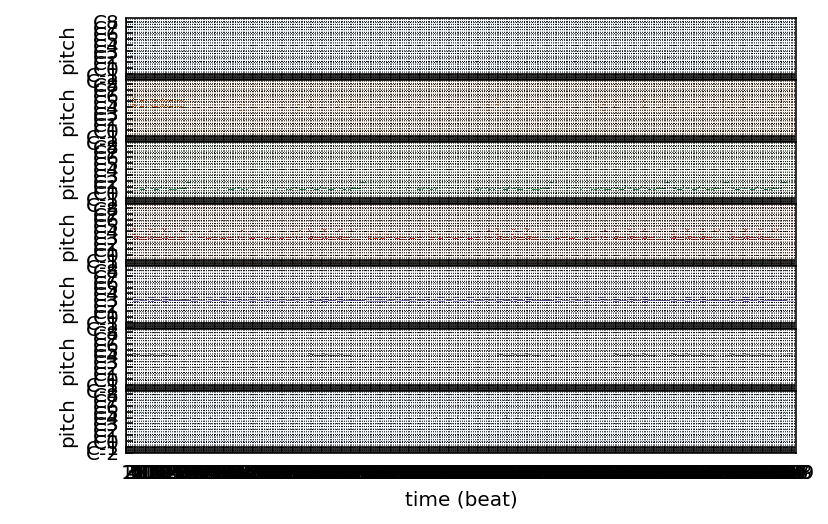

In [270]:
fig, axs = Main_multi_trk.plot()
plt.show()


In [50]:
another_multitrack.check_pianoroll

AttributeError: 'Multitrack' object has no attribute 'check_pianoroll'

In [125]:
another_multitrack

Multitrack(tracks=['', '', '', '', '', '', ''], tempo=array([75.9999696, 75.9999696, 75.9999696, ..., 54.0000054, 54.0000054,
       54.0000054]), downbeat=array([ True, False, False, ..., False, False, False]), beat_resolution=24, name=unknown)

In [85]:
drum_trk = []
piano_trk = []
base_trk = []
backup_trk = []
for trk in another_multitrack.tracks:
    if trk.is_drum:
        drum_trk.append(trk)
    if trk.program  in range(1,9):
        piano_trk.append(trk)
    if trk.program  in range(33,41):
        base_trk.append(trk)
    else:
        backup_trk.append(trk)


In [62]:
another_multitrack.tracks[for trk in another_multitrack.tracks: if trk.is_drum ]

SyntaxError: invalid syntax (<ipython-input-62-a0ee0640f475>, line 1)

In [63]:
a = another_multitrack.clip()

In [86]:
drum_trk[0].pianoroll.sum()

117728

In [87]:
piano_trk

[Track(pianoroll=array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), program=5, is_drum=False, name=)]

In [93]:
base_trk

[Track(pianoroll=array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), program=33, is_drum=False, name=)]

In [89]:
test_mul = Multitrack()
# test_mul.get_stacked_pianoroll()

In [141]:
test_mul.tracks

[Track(pianoroll=array([], shape=(0, 128), dtype=bool), program=0, is_drum=False, name=unknown)]

In [120]:
a = base_trk[0]
b = pypianoroll.clip(a,lower = 100,upper=101)

In [121]:
b.pianoroll.shape

(8856, 128)

In [128]:
pypianoroll.metrics.empty_beat_rate(piano_trk[0].pianoroll,24)

0.8455284552845529

In [132]:
beat_resolution = Main_multi_trk.beat_resolution
def get_empty_rate(trck):
    return pypianoroll.metrics.empty_beat_rate(trck.pianoroll,beat_resolution)

In [138]:
test_lst = piano_trk+drum_trk+base_trk

In [142]:
a = sorted(test_lst, key= lambda x: get_empty_rate(x))

In [210]:
def create_modify_midi(Main_multi_trk):
    drum_trk = []
    piano_trk = []
    base_trk = []
    backup_trk = []
    result_trk = Multitrack()
    for trk in Main_multi_trk.tracks:
        if trk.is_drum:
            drum_trk.append(trk)
        if trk.program  in range(1,9):
            piano_trk.append(trk)
        if trk.program  in range(33,41):
            base_trk.append(trk)
#         else:
#             backup_trk.append(trk)
#     print(backup_trk)
    if len(drum_trk)!=0 :
        sorted_drum_trk = sorted(drum_trk, key= lambda x: get_empty_rate(x))
#         print(sorted_drum_trk[0].type)
        result_trk.append_track(sorted_drum_trk[0])
#         print(result_trk.get_empty_tracks())
    if piano_trk :
        sorted_piano_trk = sorted(piano_trk, key= lambda x: get_empty_rate(x))
#         print(sorted_piano_trk)
        result_trk.append_track(sorted_piano_trk[0],sorted_piano_trk[0].pianoroll,\
                                             sorted_piano_trk[0].program,sorted_piano_trk[0].is_drum,sorted_piano_trk[0].name)
#         print(result_trk)
    if base_trk:
        sorted_base_trk = sorted(base_trk, key= lambda x: get_empty_rate(x))
        result_trk.append_track(sorted_base_trk[0])
    result_trk.remove_empty_tracks()
    return result_trk



In [203]:
pypianoroll.metrics.empty_beat_rate(a[0].pianoroll,beat_resolution)

0.8455284552845529

In [213]:
tt = create_modify_midi(Main_multi_trk)

tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown


In [215]:
tt.write('ss.mid')

In [211]:
a.append_track(drum_trk[0])

In [395]:
main_trk

Multitrack(tracks=['Acou Bass', 'G.MIDI Drums', 'SteelStrGuitar (fingers)', 'SteelStrGuitar (Thumb)', 'Nylon Guitar'], tempo=array([86.0000516, 86.0000516, 86.0000516, ..., 86.0000516, 86.0000516,
       86.0000516]), downbeat=array([ True, False, False, ..., False, False, False]), beat_resolution=24, name=unknown)

In [11]:
import glob
import os
from pypianoroll import *
import numpy as np
from pypianoroll import Multitrack, Track
from matplotlib import pyplot as plt
import scipy.misc

In [240]:
artist_list = glob.glob('clean_midi/*')

In [253]:
artist_list = glob.glob('clean_midi/*')
for art in artist_list:
    art_songs = glob.glob(art+'/*.mid')
    for song in art_songs:
        try:
            main_trk = Multitrack(song)
            modi_trk =  create_modify_midi(main_trk)
            if len(modi_trk.tracks) <3:
                continue
            modi_trk.write('3track/'+os.path.basename(song))
        except:
            continue
    

tracks : [unknown, DRUMS, E.PIANO 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, CELESTA],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown


/Users/zhengyeyang/anaconda2/envs/py3/lib/python3.5/site-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Crash, Backup (chor. piano)],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Freely, Sequenced By],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Claps, Backup (chor. piano - L)],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Tambourine, Lead (honky tonk)],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Crash, Backup II (chor. piano)],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , Arranged by Josh Chong],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Crash, Backup (chor. piano)],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Percussion, Honky tonk],
tempo : [120.],
downbeat : Non

tracks : [unknown, Quella Che Non Sei (K), Quella Che Non Sei (K)],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, drums, piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, jhuff@arinc.com],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, PIANO],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, CRASH CYMB, A.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, A.PIANO 3],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums               , Guitar 4            ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, WinJammer Demo, WinJammer Demo],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, volume],
tempo : [120.],
downbeat : None,
be

tracks : [unknown, TR808, ELECPIANO2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, ELECPIANO2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Just a Gig, Just a Gig],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums   , Melody  ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Jesahel, Jesahel],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution :

tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, SMF 0   , SMF 0   ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drummix, Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, 0235FEVR, 0235FEVR],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, MIDI, MIDI],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : un

tracks : [unknown, DRUMS  U, Piano   ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, E.piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, tremolo],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Rock Drums Set, Piano(Vocles)],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, tremolo],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Tamborine, Champagne ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, P10-ROOM KIT, P10-ROOM KIT],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Claps, Electr

tracks : [unknown, drums, chorus chords],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, drums, chorus chords],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Ch  8   , Ch  2   ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, (c)92016G, (c)92016G],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, A.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DONTLET0, DONTLET0],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, MELODY],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, verse voca

tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Il mare impetuoso...],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, MELODY],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, BLU     , BLU     ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unkno

tracks : [unknown, DRUMS, E.PIANO 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Keyboard 3 LH],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Keyboard 3 LH],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Kent Annas, WUTHERING HEIGHTS],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Kent Annas, WUTHERING HEIGHTS],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums/Percussion, Celeste],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, HARPSICHRD],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [un

tracks : [unknown, DRUMS, E.PIANO],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Lo Conga, Electric Piano2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, HARPSICHRD],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums   , Piano   ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Bright Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, tk10, tk1],
tempo : [120.],
downbeat : None,
beat_re

tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, drums, piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums   , piano   ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Grapevine, Grapevine],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Sweep Pad, Sweep Pad],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, piano 2],
tempo : [120.],
downbeat : Non

tracks : [unknown, Remixed, Specials],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, CARA             CARA, CARA             CARA],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Ciao, Ciao],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Telefonami fra vent'anni - LUCIO DALLA, Telefonami fra vent'anni - LUCIO DALLA],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unk

tracks : [unknown, DRUMS, HARPSICHRD],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, HARPSICHRD],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Nights in White     , elec. piano         ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Toms, Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums   , Piano   ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums,         ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknow

tracks : [unknown, DRUMS, CLAVINET],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums               , Steinway            ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Crash, Celesta],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, GS BY UT, GS BY UT],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums    , Steinway ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums               , Piano               ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums               , Steinway            ],
tempo : [120.],
downbeat : None,
beat_resolut

/Users/zhengyeyang/anaconda2/envs/py3/lib/python3.5/site-packages/pypianoroll/multitrack.py:817: RuntimeWarning: divide by zero encountered in true_divide
  bpm = 60.0 / np.diff(beat_times_one_more)


tracks : [unknown, GS/GM, GS/GM],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, 0368DOUT, 0368DOUT],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, I WISH                          ;Words and music by Stevie Wonder, I WISH                          ;Words and music by Stevie Wonder],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, perccusion, poly synth 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, drums, piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Charley, Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums          

tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Non gioco piu'..., Non gioco piu'...],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Brivido felino, Brivido felino],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums   , Melody  ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, UN ZEBRA A POIS, UN ZEBRA A POIS],
tempo : [120.],
downbe

tracks : [unknown, Percussion, Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Midi C5, T4         , Midi C16, T15       ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Lead],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums               , Piano Intro         ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Vocal],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Drums],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Bass],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
temp

tracks : [unknown, TIME                            ;M. Bryan / D. Felber / D. Rucker / J. "Soni" Sonefeld, TIME                            ;M. Bryan / D. Felber / D. Rucker / J. "Soni" Sonefeld],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DROWNING                        ;M. Bryan / D. Felber / D. Rucker / J. "Soni" Sonefeld, DROWNING                        ;M. Bryan / D. Felber / D. Rucker / J. "Soni" Sonefeld],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, LET HER CRY                     ;M. Bryan / D. Felber / D. Rucker / J. "Soni" Sonefeld, LET HER CRY                     ;M. Bryan / D. Felber / D. Rucker / J. "Soni" Sonefeld],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, ONLY WANNA BE WITH YOU          ;M. Bryan / D. Felber / D. Rucker / J. "Soni" Sonefeld, O

tracks : [unknown, NOTTE ROSA, NOTTE ROSA],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Analog Drums, Rhodes],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Analog Drums, Rhodes],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , Sequenced by],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, drums, drums],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Crash Cymbal, Honki Tonk Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, ElPiano,

tracks : [unknown, DRUMS, E.PIANO 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, I WillAlw, I WillAlw],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, MIDI, MIDI],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, The Great, The Great],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, 0047LOVE, 0047LOVE],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, 0178GRTL, 0178GRTL],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, IHaveNothing, IHaveNothing],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , Homepage: WWST@gmx.net],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown,

tracks : [unknown, Drums   , Piano   ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, MIDI, MIDI],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums    , Melodie  ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drum, Keyboard],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, tk10, tk1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Sad Songs    , Sad Songs    ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, tk10, tk1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, tk10, tk3],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums               , E.

tracks : [unknown, drums, elec piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, PIANO RIGHT         ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, BritePian],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Clavinet],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, CRASH               , E.PIANO-1           ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Standard , E.Piano  ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Clavinet],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Fill

tracks : [unknown, DRUMS, A.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, EPiano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Heather Duthie      , clavin              ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Bass],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums   (BB), Piano   (BB)],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
do

tracks : [unknown, Drum&SE             , kbd 1               ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drum&SE             , kbd 1               ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Electric Piano 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, STANDARD, Harpsichord],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, HARPSICHRD],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Fly Robin Fly - DEMO, Fly Robin Fly - DEMO],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, A.PIANO 2],
tempo :

tracks : [unknown, 7623HOTS, 7623HOTS],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, A.PIANO 3],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, CLAVINET],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, MIDI, MIDI],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, LUVCHNGE, LUVCHNGE],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums2, piano2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Gtr. outtro],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Brush               , Piano 2             ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks 

tracks : [unknown, DRUMS, CLAVINET],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, CLAVINET],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, HitBit  , HitBit  ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Wheel of Fortune, Wheel of Fortune],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, tk10, tk1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, 01LUCKY., 01LUCKY.],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, MIDI, MIDI],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, 01LUCKY., 01LUCKY.],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Cakewalk Home 

tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, drum 26, 8],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, CELESTA],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Ch 10   , Ch  1   ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unkn

tracks : [unknown, tom hi              , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Every Little Step, Every Little Step],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, HIGH TOM, A.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, A.PIANO 3],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, A.PIANO 3],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Acoustic Low Tom, ???],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, MIDI, MIDI],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown,

tracks : [unknown, NOTORIOUS                       ;John Taylor / Nick Rhodes / Simon Le Bon, NOTORIOUS                       ;John Taylor / Nick Rhodes / Simon Le Bon],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, VIOLIN/PNO],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Tambourine, Keyboard],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Standard            , Piano 2             ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Standard            , Piano 2             ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Standard            , Piano 2             ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, CELESTA],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Honki

tracks : [unknown, 0466BABY, 0466BABY],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, CELESTA],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, HARPSICHRD],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DICA, DICA],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, 5199GAME, 5199GAME],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, -----, -----],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Ammonic@aol.com, MIDI arranged / composed by],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, DRUMS],
t

tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, PERC, CLAV],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, THAT'S THE WAY, THAT'S THE WAY],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, That's The Way [I Like It], That's The Way [I Like It]],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, A.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, drummix, e-piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, CELESTA],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, RIDE CYMB, A.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks :

tracks : [unknown, DRUMS, A.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, I walkLine, I walkLine],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Crash   , Ges.TEMC],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,

tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Electric Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Chorused Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Everything, Everything],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Piano R],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Against O, Against O],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_reso

tracks : [unknown, Axel F, Axel F],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, (c) 1992 , (c) 1992 ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Don't Sell or Modify this file without , Copyright by:],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Harpsichord],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, CLAVINET],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, LOW TOM, A.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, CRASH CYMB, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Snare, E Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 2

tracks : [unknown, I'm Walki, I'm Walki],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, MELODY],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Timbal, ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DUBISTDI*Demixed 10, DUBISTDI*Demixed 09],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, MitvielHer, MitvielHer],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , 

tracks : [unknown, DRUMS, A.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Nikita, Nikita],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Candle Wind, Candle Wind],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drum, Harpsichord          ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, BassPiano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, untitled, untitled],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Cand

tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, R-Toms  , M-Rhodes],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, HONKY TONK],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, MID TOM, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums 10, E.piano 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums 10, Rhodes 6],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 2],
tempo : 

tracks : [unknown, HIGH CONGA, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums   (BB), Piano   (BB)],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, CRASH CYM, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, HitBit  , HitBit  ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Hello Aga, Hello Aga],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, tk10, tk3],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, swtcarol, swtcarol],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, 0105LOVE, 0105LOVE],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, MIDI, MIDI],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [un

tracks : [unknown, DRUMS, A.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, There Must Be an Angel, There Must Be an Angel],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, ROCKIT.MID, ROCKIT.MID],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, intro drums, intro piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Starman, Starman],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
te

tracks : [unknown, DRUMS, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Toms, Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, MELODY],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, tom mid 2, tom mid 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, tom high 2 48, PIANO A.3],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums               , Piano Left          ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums   , Piano   ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums   , Piano   ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks :

tracks : [unknown, BALLIAMO BALLIAMO, BALLIAMO BALLIAMO],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, L'altra donna, L'altra donna],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Padre del fuoco,del tuono,del nulla, Padre del fuoco,del tuono,del nulla],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, tk10, tk1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, POOH - CENTO DI QUESTE VITE - 2000, POOH - CENTO DI QUESTE VITE - 2000],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Io e te per altri giorni

tracks : [unknown, Giorni infiniti, Giorni infiniti],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Che vuoi che sia, Che vuoi che sia],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, LE DONNE ITALIANE, LE DONNE ITALIANE],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drum, Bell],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, CERCANDO DI TE, CERCANDO DI TE],


tracks : [unknown, Drums, Clavinet 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, untitled, untitled],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums         , Mellotron     ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Clavinet],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drum, Keyboard 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, percussion, piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Piano],
tempo :

tracks : [unknown, Channel 10, Channel 12],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, EV Drumz, Bell Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, ForAFewDollarsMore, ForAFewDollarsMore],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, A.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, ElPiano1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : No

tracks : [unknown, percussion, rythm clav],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, tk10, tk4],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, drums, clav rhythm],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, drums, piano 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, drums, piano 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , Guitar 1 (E.C.)],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, LAY DOWN SALLY                  ;Eric Clapton / Marcella Levy / George Terry, LAY DOWN SALLY                  ;Eric Clapton / Marcella Levy / Georg

tracks : [unknown, drums, Harpsichord],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Sing (Carpenters), Sing (Carpenters)],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, SHAKER              , HARPSICOR           ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Piano Riff],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Grand Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, We've Onl, We've Onl],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
na

tracks : [unknown, , Elec Piano          ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, WinJammer Demo, WinJammer Demo],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Piano-Detuned Fender Rhodes],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, cymbal roll end, acoustic pno],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Cymbal roll end, Acoustic Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, 0320SAVE, 0320SAVE],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, cymbal roll end, acoustic pno],
tempo : [120.],
downbeat : None,
beat_

tracks : [unknown, Gente della notte, Gente della notte],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, 0196PLJR, 0196PLJR],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Ebony And Ivory, Ebony And Ivory],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Band on the Run, Band on the Run],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, LET 'EM IN       10 , LET 'EM IN          ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
trac

tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, DRUMS],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, WouldIlie, WouldIlie],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, CRASH CYMB, E.PIANO 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, TAMBOURINE, E.PIANO 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Electric Piano      ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, WinJammer Demo, WinJammer Demo],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, WinJammer, WinJammer],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [

tracks : [unknown, Percussion, Keyboard],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, A.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, C10-Drums & Percussi, MOON DANCE          ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums*STANDARD      , Piano 2             ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, C10-Drums & Percussi, MOON DANCE          ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Melody 4],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Drums],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Extra Perc, Elec Piano],
tempo : [120.],
downbeat : No

tracks : [unknown, drums, elecpiano1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Bette Davis Eyes, Bette Davis Eyes],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, tk10, tk7],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, A.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Reality, Reality],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Reality, Reality],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, A.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Drums],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, CRASH CYMB, A.P

tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, tk10, tk7],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, drums, synth.L],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, (single version), (single version)],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, A.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, ISTHISLV, ISTHISLV],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Hihat open, El. piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Keyboard 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , Go],
tempo : [120.

tracks : [unknown, Drums, Elec Pf],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, A.PIANO 3],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, SNARE DRUM, A.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, MonaLisa, MonaLisa],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Analog Tom, Harpsi],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums   (BB)        , Piano   (BB)        ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Honky Tonk],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Synth Brass 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name 

tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, 7402MRSJ, 7402MRSJ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, 0389RNIT, 0389RNIT],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, A.PIANO 3],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, 0540STUK, 0540STUK],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, GS/GM DRUMS         , El Piano            ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, 0021HELL, 0021HELL],
tempo : [120

tracks : [unknown, ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Kurt Cobain-Vocals],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , Tracked by RazTor (cns@post7.tele.dk)],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Chad Chunning -Drums-, Kurt Cobain -Vocals-],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Kurdt Kobain -Guitar-],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, All Apologies -Record Ver, All Apologies -Record Ver],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Kurdt Kobain -Guitar-],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Dave Grohl -Drums-, Kurt Cobain -Clean Guitar-],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Dave 

tracks : [unknown, Sp. night, Sp. night],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Portofino, Portofino],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, HARPSICHRD],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums   , Piano   ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, SD, Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Tambourin, Ac Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Get down, Get down],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 1],
tempo : [

tracks : [unknown, DRUMS, A.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Lovemachin, Lovemachin],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, HARPSICHRD],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, 0006EARH, 0006EARH],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Lei, Lei],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, KUNACIOCCADICAPELLI ADAMO, KUNACIOCCADICAPELLI ADAMO],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [

tracks : [unknown, DRUMS, E.PIANO 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, May 9th 1997        , May 9th 1997        ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Elevation, Elevation],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, I STILL HAVEN'T FOUND WHAT I'M LOOKING FOR;P. Hewson / D. Evans / A. Clayton / L. Mullen, I STILL HAVEN'T FOUND WHAT I'M LOOKING FOR;P. Hewson / D. Evans / A. Clayton / L. Mullen],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Melody 6],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, NEW YEAR'S DAY                  ;P. Hewson / D. Evans / A. Cla

tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUM, HONKYTONK],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Orchestra Hits],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, MELODY],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Amando amando, Amando amando],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUM, PIANO],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, El. Piano],
tempo : [120.],
downbeat : None,
beat_

tracks : [unknown, drums, drums],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, H TOM, PIANO],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums   , El.Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, StdKit2, StdKit2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums*, Clavinet*],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, drums, drums],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, drums               , GT                  ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums*, Clavinet*],


tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, CaliforniaBlue, CaliforniaBlue],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Tom Tom , Ac.Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, A.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, SNARE DRU, E.PIANO],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, RIDE CYMB, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Written by Roy Orbison & Jeff Lynne, ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, A

tracks : [unknown, Seq. by Rob Durfee, Seq. by Rob Durfee],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Bad Girl, Bad Girl],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Celesta],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DROWNEDW, DROWNEDW],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Piano1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, A.PIANO 3],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Electric Piano],

tracks : [unknown, CASTANETS, E.PIANO],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Rain, Rain],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Percussion, Rhodes Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, this song., TopHand Introduction],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, NOTHINGR, NOTHINGR],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, IntoGroove, IntoGroove],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, A.PIANO 3],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
temp

tracks : [unknown, Drums, E.Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Ac Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown,  Drums,  String.type],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, by PINK FLOYD, by PINK FLOYD],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Rhythm&SE           , Tuba/Pian2          ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, HEY YOU by R.Waters & Pink Floyd, HEY YOU by R.Waters & Pink Floyd],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Percussion, Elect Piano],
tempo : [120.],
downbeat : Non

tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, ARCOBALEN, ARCOBALEN],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Words, Words],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [un

tracks : [unknown, Drums 10, Rhodes 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Hi Timbale, Kick],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Track10, Track1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, EXTERMIN, EXTERMIN],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, A.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Piano],
tempo : [12

tracks : [unknown, DRUMS, CLAVINET],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, A.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, harpsichord],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, FIND AN , FIND AN ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Accompaniment, Accompaniment],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Maniac, Maniac],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Track 10, Track 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, mona-mona, mo

tracks : [unknown, DRUMS, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, MID TOM, A.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , MCPI],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, CLAVINET],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Voyage V., Voyage V.],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, MARE INVER, MARE INVER],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, MISTERO         , MISTERO         ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Il Porti, Il Porti

tracks : [unknown, Drums, Drums],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, BRASS 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Rhythm&SE           , Piano               ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Roland Drums, ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Words],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Closed Hi-Hat, Clavinet],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, A.PIANO 2],
tempo : [120.],
do

tracks : [unknown, tk10, tk10],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, LOVEME  , LOVEME  ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, A.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, MIDI, MIDI],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums   , Piano   ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, FILLS],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolu

tracks : [unknown, Std Drums, Rhodes Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Johnny B. Goode, Johnny B. Goode],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Std Drums, E. Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, PIANO],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, VOCAL],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, GM Drums            , perc. organ         ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, WinJammer Demo],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Std Drums, E. Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unkno

tracks : [unknown, Crash Cymbal, Rock Organ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, HIGH TOM, E.PIANO],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Jazz Drums, Jazz Drums],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Snare Drum      , Piano 2         ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, TAMBORINE, Piano2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Std Drum Set, Chorused Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, WinJammer Demo, WinJammer Demo],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, HIGH TOM, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat

tracks : [unknown, Drums, Organ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Piano 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, drums, ep],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Percussion, Piano 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Tromb/Pian],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, PIANO],
tempo : [120.],
downbeat : None,
beat_r

tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Crash Cymbal        , Brass 2             ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Rhythm&SE, Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Incidential Noises, More crap.],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Piano 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, PIANO2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Std Drums, Piano - Honky Tonk],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Rhythm, Ma

tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, El Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, El Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, tk10, tk6],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, StuckWithYou, StuckWithYou],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, LOW TOM, A.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, OPEN HIHAT, A.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_

tracks : [unknown, 0046MISS, 0046MISS],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, HARPSICHRD],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, MIDI, MIDI],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, A.PIANO],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Icantgeten, Icantgeten],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, 626 drum machine, electric piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Tom low, Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Low Tom 2, Piano 3],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, HTTP://WWW.EFRANSEN.DEMON.NL, HTTP://WWW.EFRANSEN.DEMON.NL],
tempo : [120.],
downbeat : None,
beat_r

tracks : [unknown, MUSICAE , MUSICAE ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, ANCORAUN, ANCORAUN],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Batteria, Piano   ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, PIUBELLA, PIUBELLA],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, ADESSOTU, ADESSOTU],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution :

tracks : [unknown, Autumn Leaves, Autumn Leaves],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, LOW TOM, A.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Piano 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Piano 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, REMIX BY STEVE, ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Bon Jovi - It's My Life, Bon Jovi - It's 

tracks : [unknown, DRUMS, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, You Can Leave Your...],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, WITHALIT.MID , WITHALIT.MID ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, untitled, untitled],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums               , Bells               ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, EndOfRoad GM, EndOfRoad GM],
tempo : [120.],
downbeat : None,
beat_resol

tracks : [unknown, Drums, Electric Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Livin' La Vida Loca, Sequenced for TopList Team],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, LOADED  , LOADED  ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Electric Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, This one is better!, www.geocities.com/~lbb/],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums           , Drums           ],
tempo : [120.],
downbeat : None,
beat_resolution : 

tracks : [unknown, DRUMS, SYN STR 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Toms, Harpsi],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, 0317SUMR, 0317SUMR],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, CELESTA],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Yellow Ri, Yellow Ri],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, MIDI, MIDI],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Main Voice],
tempo : [120.

tracks : [unknown, Drums, Keyboard2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Organ 3],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Keyboard2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Keyboard2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, A.PIANO 3],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, E.Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, PRG.CHANGE],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, PRG.CHANGE],
tempo : [120.],
down

tracks : [unknown, Remixed, Remixed],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Percussion, Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown,   CR-78 Kick2, Piano RH],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, 5041LUV4, 5041LUV4],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, More Drums, Piano         ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, drums, chorus chords],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Mandela Day, Mandela Day],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unkn

tracks : [unknown, DRUMS, DRUMS],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, OPEN HIHAT, A.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Clavinet],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums / Handclaps (Percussion), Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, A.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, JustTheWay, JustTheWay],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, MID TOM, E

tracks : [unknown, untitled, untitled],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, A.PIANO],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Every Breath, Every Breath],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,

tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, REVERB SNARE, Vibraphone],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, SNARE, E.Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums   , ElPiano2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, OPEN HIHAT, Acoustic guitar],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, CONGA HI, Acoustic guitar],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Ch  2   ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Dru

tracks : [unknown, Drums, Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Harpsichord],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Percussion, Piano Echo],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Drums],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums   , Drums   ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Acoustic Grand Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Vocals],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, WinJammer Demo, WinJammer Demo],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown,

tracks : [unknown, Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Harpsichord],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, IN MY ROOM - The Beach Boys, IN MY ROOM - The Beach Boys],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums  , Guitar  ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, HONKY TONK],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Piano 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Honky Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Clav],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
trac

tracks : [unknown, NEL CUORE NELL'ANIMA, NEL CUORE NELL'ANIMA],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Canto],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, 1AVVENTU, 1AVVENTU],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Sint.],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Batt., Canto],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Canto],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, CONILNAS  CON IL NASTRO ROSA, CONILNAS  CON IL NASTRO ROSA],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],

tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, untitled, untitled],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, drums b6, main melody (s)],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, ElecPiano/PercOrgan],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, drums, piano1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, 2 Drums, lead],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, A.PIANO 3],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Misunderstanding / Genesis                    ;by KEPEMusic Ltd., Misunderstanding / Genesis                    ;by KEPEMusic Ltd.

tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, drum 1, 6],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Sequenced by Purwanto N (JazzStyle), Sequenced by Purwanto N (JazzStyle)],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, All That I Need, All That I Need],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Side Stic, Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Side Stick, Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, ElecPiano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, CRASH CYM, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
n

tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, _ , Jens@FreshMidis.com ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , Phantom],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Perc, ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, PLEASE E-MAIL, ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, MIDI Drum Stuff, Harpsichord],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, hihat1, steinway],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, A.PIANO 2],
tempo : [120.],
downbea

tracks : [unknown, RHYTHM, LS 2],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums / Brush    , Melody / Rhodes Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, KILLSOFT, KILLSOFT],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, drums, elec piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, GM Drum Kit, Digital Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, RIDE CYMB, E.PIANO 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Solo con l'anima mia, Solo con l'anima mia],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, CLAVINET],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, drums, supercat],
tempo : [120.],
downbeat : None,
beat

tracks : [unknown, Open Hi Hat, Piano (Treble)      ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Cymbal, Rhodes],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Piano ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Radio Gaga, Radio Gaga],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Keyboard 4 (Bass)   , Kybrd 2 (Clavinet)  ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, HARPSICHRD],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, SEA_RH

tracks : [unknown, Drums, Bright Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DOES YOUR MOTHER KNOW           ;Benny Andersson / Bjorn Ulvaeus, DOES YOUR MOTHER KNOW           ;Benny Andersson / Bjorn Ulvaeus],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Mama Mia, Mama Mia],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, tk10, tk7],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Thenameof, Thenameof],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, SuperTrooper, SuperTrooper],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Knowing, Knowing],


tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Winner Takes It All, Winner Takes It All],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, M #10, M #5],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, MIDI, MIDI],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, MID TOM, E.PIANO 2],
tempo : [120.],
downbeat : None,
beat_resolut

tracks : [unknown, Drums, Drums],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums, Piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drums   , Piano (Melody)],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, BABE    , BABE    ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, A.PIANO 3],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, CELESTA],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resoluti

tracks : [unknown, Dreamlover, Dreamlover],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO 1],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Echo, Echo],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, drums, piano],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, 06FANTAS, 06FANTAS],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, DRUMS, E.PIANO],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Someday   GS, Someday   GS],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, , ],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, Drumz, Mariah],
tempo : [120.],
downbeat : None,
beat_resolution : 24,
name : unknown
tracks : [unknown, untitled, untitled],

In [248]:
os.path.basename(art_songs[0])

'When the Children Cry.mid'

In [251]:
len(modi_trk.tracks)

2

In [315]:
test_roll = modi_trk.tracks[0].pianoroll

In [338]:
modi_trk.tracks[0].pianoroll+20

array([[20, 20, 20, ..., 20, 20, 20],
       [20, 20, 20, ..., 20, 20, 20],
       [20, 20, 20, ..., 20, 20, 20],
       ...,
       [20, 20, 20, ..., 20, 20, 20],
       [20, 20, 20, ..., 20, 20, 20],
       [20, 20, 20, ..., 20, 20, 20]], dtype=uint8)

In [339]:
modi_trk.write('single_ye.mid')

In [326]:
import matplotlib.pyplot as plt  
import matplotlib.image as mpimg

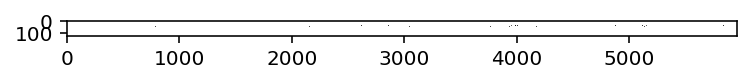

In [331]:
imgplot = plt.imshow(255-test_roll.T,cmap = 'gray')

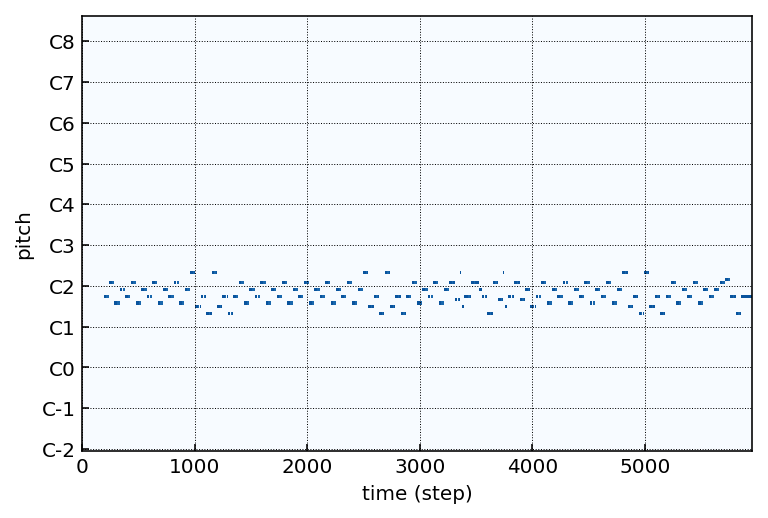

In [466]:
fig, ax = main_trk.tracks[3].plot()
plt.show()

In [467]:
main_trk.tracks[3].pianoroll[2011]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 100,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=uint8)

In [468]:
a = main_trk.tracks[3].copy()

In [359]:
a.binarize()

In [362]:
a.pianoroll[2011]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]

In [471]:
b = a.pianoroll[2000:2096,:].copy()

In [381]:
b[b ==False].

(10600,)

In [454]:
main_trk=Multitrack(song)

In [455]:
c =  main_trk.tracks[2]

In [456]:
d = c.pianoroll[0:100,0:128]
c.pianoroll = d

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0xa215b1b38>)

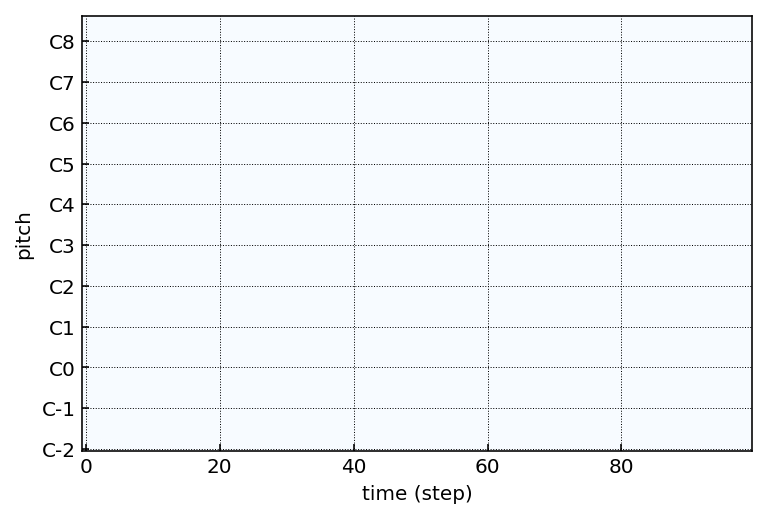

In [460]:
c.plot()

In [458]:
m_c = Multitrack()
m_c.tracks.append(c)

In [459]:
m_c.write('short_dum.mid')

In [393]:

scipy.misc.imsave('outfile.png', d.T)

/Users/zhengyeyang/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


In [406]:
a =multi_image2midi('outfile.png')

(106, 100, 3)


In [478]:
test_img = np.dstack((bb,bb,bb))

In [495]:
scipy.misc.imsave('outfile.png', cc)

/Users/zhengyeyang/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """Entry point for launching an IPython kernel.


In [463]:
 d.T[d.T>0] = 255

In [553]:
tone = np.ones((3,4))
tone[2,0]=2

In [555]:
tone[tone>1]=255

In [556]:
tone

array([[  1.,   1.,   1.,   1.],
       [  1.,   1.,   1.,   1.],
       [255.,   1.,   1.,   1.]])

In [476]:
bb[bb>0] =255

In [493]:
cc = np.transpose(bbb,axes = (1,0,2))

In [491]:
bbb = np.dstack((bb,bb,bb))

In [492]:
bbb.shape

(96, 128, 3)

In [494]:
cc.shape

(128, 96, 3)

In [498]:
len(modi_trk.tracks)

1

In [500]:
multi_image2midi('outfile.png')

(128, 96, 3)


[<music21.note.Note C>,
 <music21.note.Note E->,
 <music21.note.Note C#>,
 <music21.note.Note G>,
 <music21.note.Note G>,
 <music21.note.Note B>,
 <music21.note.Note B>]

In [518]:
c_test = Multitrack('single_ye.mid')

(<Figure size 432x288 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0xa241ff860>])

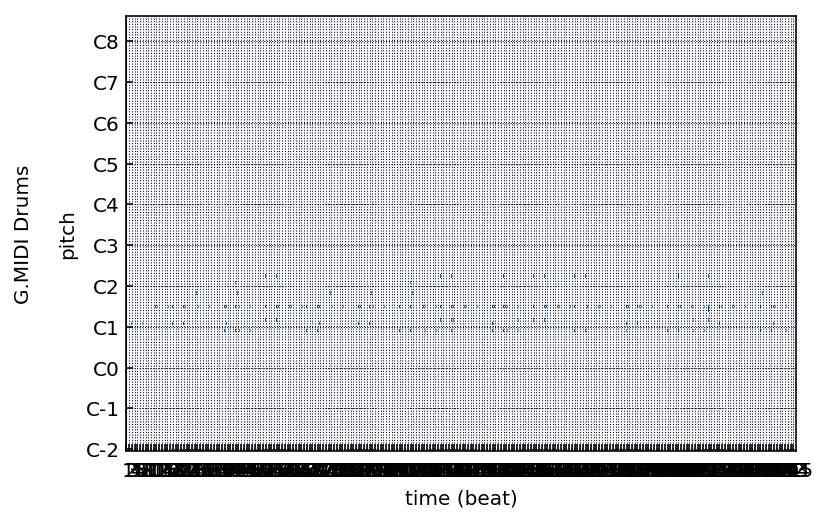

In [519]:
c_test.plot()

In [521]:
c_test.tracks[0].pianoroll.shape

(5880, 128)

In [528]:
tr1.pianoroll.shape

(96, 128)

# create 3-channel img from modified midi

In [6]:
def midi_img(midi_dir,output_dir,repetition,downsample_rate=1):
    midi_list = glob.glob(midi_dir)
    print('total number of midi',len(midi_list))
    cnt = 0
    for song in midi_list:
        if cnt% (0.1* len(midi_list))==0:
            print('processed songs:',cnt)
        song_img = _midi_img(song,repetition,downsample_rate)
        if len(song_img) ==0:
            print('empty song')
            continue
        else :
            img_id =0
            song_base = os.path.basename(song)
            for img in song_img:
                scipy.misc.imsave(output_dir+song_base+'_'+str(img_id)+'.png', img)
                img_id +=1
        cnt+=1
def _midi_img(input_midi,repetition,downsample_rate):
    try:
        song = Multitrack(input_midi)
        song.downsample(downsample_rate)
    #check num of tracks:
        song.remove_empty_tracks()
        if len(song.tracks) != 3:
            print('not 3 tracks midi')
            return []
        else:
            song_len = song.tracks[0].pianoroll.shape[0]
            if song_len<96:
                print('tracks too short ',song_len)
                return []
            for trk in song.tracks:
                if trk.is_drum:
                    drum_roll = trk.pianoroll
                if trk.program in range(1,9):
                    piano_roll = trk.pianoroll
                if trk.program in range(33,41):
                    base_roll = trk.pianoroll
            #then binarize the value
            drum_roll[drum_roll> 0 ]=255
            piano_roll[piano_roll> 0 ]=255
            base_roll[base_roll> 0 ]=255
#             print(piano_roll.shape)
            image_list = []
#             print(min(song_len // 96,repetition) )
            for i in range(min(song_len // 96,repetition)):
                
                temp_img = np.dstack((drum_roll[i*96:96*(1+i),:],piano_roll[i*96:96*(1+i),:],base_roll[i*96:96*(1+i),:]))
                
                image_list.append(temp_img)
                
    except IndexError :
        print('what')
        return [] 
    return image_list
                
                

In [12]:
midi_dir = 'merge_3track/*.mid'
output_dir = 'down_sample_merge_img/'
repetition = 30
midi_img(midi_dir,output_dir,repetition,downsample_rate=2)

total number of midi 5595
processed songs: 0


/Users/zhengyeyang/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  app.launch_new_instance()


not 3 tracks midi
empty song
not 3 tracks midi
empty song
not 3 tracks midi
empty song
not 3 tracks midi
empty song
not 3 tracks midi
empty song
not 3 tracks midi
empty song
not 3 tracks midi
empty song
not 3 tracks midi
empty song
not 3 tracks midi
empty song
processed songs: 1119
not 3 tracks midi
empty song
not 3 tracks midi
empty song
processed songs: 2238


EOFError: 

In [660]:
img_set = set()

In [ ]:
img_set.add

In [287]:
audio_path = 'output.wav'
import IPython.display as ipd
ipd.Audio(audio_path)

# reverse img to midi

In [280]:
def filter_max(array):
    
    aa = np.zeros(array.shape)

    for i in range(array.T.shape[0]):
        if array.T[i].max() > 0:
            aa.T[i][array.T[i].argmax()] =255
        else:
            continue
    
    return aa

In [304]:
tst_trk.beat_resolution = 12

In [308]:
img_list = glob.glob('test_data/*')
sorted(img_list)
img_set = []
for img in img_list:
    temp = scipy.misc.imread(img)
    print(temp.shape)
    
#     temp = np.transpose(temp,(1,0,2))
#     temp = cv2.resize(temp,(96,128))
#     temp = cv2.flip(temp,0)
    print(temp.shape)
    img_set.append(temp)
dd = np.hstack(img_set)
scipy.misc.imsave('haha-13.png',dd)

cc = scipy.misc.imread('haha-13.png')# cc = np.transpose(bbb,axes = (1,0,2))
cc[cc<255/(4)] =0
tst_trk = Multitrack()
tr1 = pypianoroll.Track(np.transpose(cc[:,:,0]),program=0, is_drum=True,name='drum')
tr2 = pypianoroll.Track(np.transpose(filter_max(cc[:,:,1])),program=1, is_drum=False,name='piano')
tr3 = pypianoroll.Track(np.transpose(filter_max(cc[:,:,2])),program=33, is_drum=False,name='base')
tst_trk.append_track(tr1)
tst_trk.append_track(tr2)
tst_trk.append_track(tr3)
tst_trk.remove_empty_tracks()
tst_trk.beat_resolution = 12
tst_trk.write('200_filter_outfile.mid')

/Users/zhengyeyang/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)

(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)
(128, 96, 4)

/Users/zhengyeyang/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  
/Users/zhengyeyang/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()


In [127]:
cc[:,:,2]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,  79, 115,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  60,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=uint8)

In [224]:
b = np.array([[0,0,0,0],[0,2,1,0],[3,1,0,0]])
b.shape

(3, 4)

In [226]:
c = np.array([[1],[2],[3]])
c.shape

(3, 1)

In [227]:
c-b

array([[1, 1, 1, 1],
       [2, 0, 1, 2],
       [0, 2, 3, 3]])

In [273]:
a.T.shape[0]

960

In [276]:
a=cc[:,:,0]
aa = np.zeros(a.shape)
a.shape
for i in range(a.T.shape[0]):
    aa.T[i][a.T[i].argmax()] =255


In [277]:
scipy.misc.imsave('haha-1113.png',aa)

/Users/zhengyeyang/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """Entry point for launching an IPython kernel.


In [254]:
aa[:,64]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [219]:
p = a - a.max(axis= 0,keepdims=True) 
p[p==0] = 255
p[p<255]=0

In [215]:
a.max(axis= 0,keepdims=True) [:,0]

array([67], dtype=uint8)

In [220]:
p[:,0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=uint8)

In [196]:
a.max(axis= 0,keepdims=True) .shape

(1, 960)

In [197]:
a.shape

(128, 960)

In [700]:
pp = np.transpose(cc[:,:,0])+np.transpose(cc[:,:,1])

In [178]:
a - a.max(axis= 0,keepdims=True) 

array([[189, 198,   0, ..., 189, 194, 201],
       [189, 198,   0, ..., 189, 194, 201],
       [189, 198,   0, ..., 189, 194, 201],
       ...,
       [189, 198,   0, ..., 189, 194, 201],
       [189, 198,   0, ..., 189, 194, 201],
       [189, 198,   0, ..., 189, 194, 201]], dtype=uint8)

(<Figure size 432x288 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0xd308c9668>,
       dtype=object))

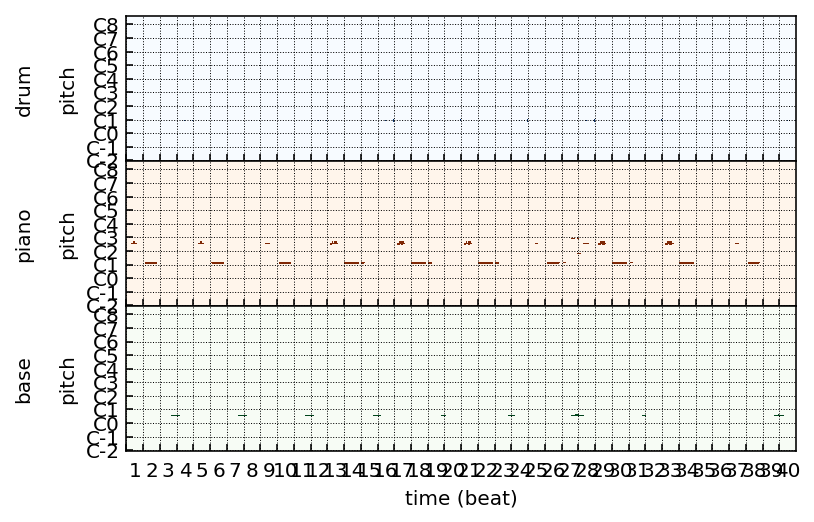

In [699]:
tst_trk.plot()

In [686]:
scipy.misc.imsave('1-12.png',np.transpose(cc[:,:,1]))

/Users/zhengyeyang/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """Entry point for launching an IPython kernel.


In [298]:
cc = scipy.misc.imread('fake62.png')# cc = np.transpose(bbb,axes = (1,0,2))
print(cc.shape)
# cc = cv2.resize(cc,(128,96))
# print(cc.shape)
# cc = np.transpose(cc,(1,0,2))
# print(cc.shape)
# scipy.misc.imsave('put001.jpg',cc)
# cc = cv2.flip(cc,0)
cc[cc<255/4] =0
tst_trk = Multitrack()
tr1 = pypianoroll.Track(np.flipud(np.transpose(cc[:,:,0])),program=0, is_drum=True,name='drum')
tr2 = pypianoroll.Track(np.flipud(np.transpose(cc[:,:,1])),program=1, is_drum=False,name='piano')
tr3 = pypianoroll.Track(np.flipud(np.transpose(cc[:,:,2])),program=33, is_drum=False,name='base')
tst_trk.append_track(tr1)
tst_trk.append_track(tr2)
tst_trk.append_track(tr3)
tst_trk.remove_empty_tracks()
tst_trk.write('re_outfile0.mid')

(128, 96, 4)


/Users/zhengyeyang/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


In [80]:
np.flipud(cc[:,:,0]).shape

(128, 96)

In [81]:
tst_trk.write('re_outfile.mid')

In [43]:
# gen_trk = Multitrack('re_outfile.mid')

ValueError: Cannot get beat timings to quantize pianoroll.

In [22]:
gen_trk

Multitrack(tracks=['drum', 'piano', 'base'], tempo=array([120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
       120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
       120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
       120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
       120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
       120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
       120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
       120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
       120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
       120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
       120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
       120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
       120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,


In [706]:
def create_midi_img(img_trk):
    drum_trk = []
    piano_trk = []
    base_trk = []
    backup_trk = []
    result_trk = Multitrack()
    for trk in Main_multi_trk.tracks:
        if trk.is_drum:
            drum_trk.append(trk)
        if trk.program  in range(1,9):
            piano_trk.append(trk)
        if trk.program  in range(33,41):
            base_trk.append(trk)
#         else:
#             backup_trk.append(trk)
#     print(backup_trk)
    if len(drum_trk)!=0 :
        sorted_drum_trk = sorted(drum_trk, key= lambda x: get_empty_rate(x))
#         print(sorted_drum_trk[0].type)
        result_trk.append_track(sorted_drum_trk[0])
#         print(result_trk.get_empty_tracks())
    if piano_trk :
        sorted_piano_trk = sorted(piano_trk, key= lambda x: get_empty_rate(x))
#         print(sorted_piano_trk)
        result_trk.append_track(sorted_piano_trk[0],sorted_piano_trk[0].pianoroll,\
                                             sorted_piano_trk[0].program,sorted_piano_trk[0].is_drum,sorted_piano_trk[0].name)
#         print(result_trk)
    if base_trk:
        sorted_base_trk = sorted(base_trk, key= lambda x: get_empty_rate(x))
        result_trk.append_track(sorted_base_trk[0])
    result_trk.remove_empty_tracks()
    return result_trk

def merge_trk(track_list,merge):
    if merge == False:
        return track_list[0]
    else:
        
        for i in range(len(track_list)):
            if i ==0:
                continue
            else :
                track_list[0].pianoroll +=track_list[i].pianoroll
        return track_list[0]
    


In [711]:
def test_create_modify_midi(Main_multi_trk,merge = False):
    drum_trk = []
    piano_trk = []
    base_trk = []
    backup_trk = []
    result_trk = Multitrack()
    for trk in Main_multi_trk.tracks:
        if trk.is_drum:
            drum_trk.append(trk)
        if trk.program  in range(1,9):
            piano_trk.append(trk)
        if trk.program  in range(33,41):
            base_trk.append(trk)
#         else:
#             backup_trk.append(trk)
#     print(backup_trk)
    if len(drum_trk)!=0 :
#         print('drum trk number',len(drum_trk))
        sorted_drum_trk = sorted(drum_trk, key= lambda x: get_empty_rate(x))
#         print(sorted_drum_trk[0].type)
        tmp_trk = merge_trk(sorted_drum_trk,True)
        result_trk.append_track(tmp_trk)
#         print(result_trk.get_empty_tracks())
    if piano_trk :
#         print('piano trk number',len(piano_trk))
        sorted_piano_trk = sorted(piano_trk, key= lambda x: get_empty_rate(x))
#         print('ori',np.sum(sorted_piano_trk[0].pianoroll))
        tmp_trk = merge_trk(sorted_piano_trk,True)
#         print('merge',np.sum(tmp_trk.pianoroll))
        result_trk.append_track(tmp_trk)
#         print(result_trk)
    if base_trk:
#         print('piano trk number',len(piano_trk))
        sorted_base_trk = sorted(base_trk, key= lambda x: get_empty_rate(x))
        tmp_trk = merge_trk(sorted_base_trk,True)
        result_trk.append_track(tmp_trk)
    result_trk.remove_empty_tracks()
    return result_trk




In [716]:
artist_list = glob.glob('clean_midi/*')
print('num of artist:',len(artist_list))
cnt =0
for art in artist_list:
    if cnt% int(0.1*len(artist_list) )==0:
        print('finished{}{}'.format(cnt,len(artist_list)))
    art_songs = glob.glob(art+'/*.mid')
    for song in art_songs:
        try:
            
            main_trk = Multitrack(song)
            modi_trk =  test_create_modify_midi(main_trk)
            if len(modi_trk.tracks) <3:
                continue
            modi_trk.write('merge_3track/'+os.path.basename(song))
        except:
            continue
    

num of artist: 2199
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
drum trk number 2
piano trk number 0
finished02199
drum trk number 1
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 2
ori 124565
merge 959882
piano trk number 2
finished02199
drum trk number 1
finished02199
drum trk number 1
piano trk number 1
ori 422729
merge 422729
drum trk number 3
finished02199


/Users/zhengyeyang/anaconda2/envs/py3/lib/python3.5/site-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


drum trk number 2
piano trk number 2
ori 110164
merge 206206
piano trk number 2
drum trk number 3
drum trk number 5
piano trk number 1
ori 303791
merge 303791
piano trk number 1
drum trk number 1
piano trk number 1
ori 2322341
merge 2322341
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 5
piano trk number 4
ori 15765
merge 833462
piano trk number 4
drum trk number 1
piano trk number 0
drum trk number 4
piano trk number 1
ori 476124
merge 476124
piano trk number 1
drum trk number 1
drum trk number 6
piano trk number 2
ori 212100
merge 611542
piano trk number 2
drum trk number 2
piano trk number 2
ori 246868
merge 497566
piano trk number 2
drum trk number 5
piano trk number 1
ori 303791
merge 303791
piano trk number 1
drum trk number 3
piano trk number 0
drum trk number 3
drum trk number 2
piano trk number 3
ori 425435
merge 631073
piano trk number 3
drum trk number 1
piano trk number 0
drum trk number 2
drum trk number 2
piano trk number 1
ori 1188588
merge 1188

drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 3
ori 842370
merge 2023699
piano trk number 3
drum trk number 1
piano trk number 0
drum trk number 6
piano trk number 1
ori 715183
merge 715183
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 136758
merge 136758
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 1
ori 1960811
merge 1960811
piano trk number 1
finished02199
drum trk number 1
piano trk number 2
ori 868443
merge 2354968
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 2
piano trk number 0
drum trk number 2
piano trk number 0
drum trk number 1
piano trk number 1
ori 1940027
merge 1940027
piano trk number 1
drum trk numbe

finished02199
drum trk number 1
piano trk number 0
drum trk number 3
drum trk number 8
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
drum trk number 1
piano trk number 1
ori 39200
merge 39200
drum trk number 1
drum trk number 1
drum trk number 1
drum trk number 1
drum trk number 1
piano trk number 0
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 1
ori 375760
merge 375760
drum trk number 1
drum trk number 1
piano trk number 1
ori 623440
merge 623440
drum trk number 1
piano trk number 1
ori 106720
merge 106720
drum trk number 1
piano trk number 1
ori 1109856
merge 1109856
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
drum trk number 1
drum trk number 1
piano trk number 1
ori 2043775
merge 2043775
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 6
piano trk number 0
drum trk number 1
piano trk number 1

drum trk number 1
piano trk number 2
ori 674121
merge 5176637
piano trk number 2
finished02199
drum trk number 1
piano trk number 1
ori 167183
merge 167183
piano trk number 1
drum trk number 1
piano trk number 1
ori 1675230
merge 1675230
piano trk number 1
finished02199
drum trk number 1
piano trk number 1
ori 153114
merge 153114
piano trk number 1
drum trk number 1
piano trk number 1
ori 206985
merge 206985
piano trk number 1
drum trk number 1
piano trk number 1
ori 153198
merge 153198
piano trk number 1
drum trk number 1
piano trk number 1
ori 2691148
merge 2691148
piano trk number 1
finished02199
drum trk number 8
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 8
piano trk number 2
ori 20084
merge 1333450
piano trk number 2
finished02199
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 1
ori 1088506
merge 1088506
drum trk number 1
piano trk number 1
ori 776836
merge 776836
piano trk number 1


drum trk number 1
piano trk number 1
ori 351917
merge 351917
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 378474
merge 792191
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 975614
merge 975614
piano trk number 1
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 2344715
merge 2344715
piano trk number 1
drum trk number 1
piano trk number 1
ori 2192306
merge 2192306
drum trk number 1
piano trk number 1
ori 516276
merge 516276
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 1388357
merge 1567626
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 2190953
merge 2190953
piano trk number 1
drum trk number 1
piano trk number 1
ori 670618
merge 670618
piano trk number 1
drum trk number 1


drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 1
ori 140622
merge 140622
piano trk number 1
finished02199
drum trk number 1
finished02199
drum trk number 1
finished02199
drum trk number 1
drum trk number 1
finished02199
drum trk number 2
piano trk number 2
ori 1260575
merge 4132298
piano trk number 2
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 1
ori 2524927
merge 2524927
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 2522519
merge 2522519
piano trk number 1
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 797457
merge 797457
piano trk number 1
finished02199
drum trk number 1
piano trk number 1
ori 898101
merge 898101
piano trk number 1
finished02199
drum trk number 1
piano trk number 0
drum trk number 4
piano trk number 0
drum trk number 1
piano trk number 1
ori 30

drum trk number 1
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 97606
merge 97606
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 2
ori 13356
merge 261828
piano trk number 2
finished02199
drum trk number 1
finished02199
drum trk number 1
piano trk number 0
drum trk number 10
finished02199
finished02199
drum trk number 1
piano trk number 1
ori 111100
merge 111100
piano trk number 1
drum trk number 2
drum trk number 1
piano trk number 0
piano trk number 1
ori 129100
merge 129100
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk num

drum trk number 1
piano trk number 1
ori 1304800
merge 1304800
piano trk number 1
drum trk number 1
piano trk number 1
ori 324266
merge 324266
drum trk number 1
piano trk number 1
ori 2512356
merge 2512356
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 930533
merge 930533
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 355368
merge 2364605
piano trk number 2
drum trk number 1
drum trk number 1
piano trk number 2
ori 35983
merge 310671
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 930523
merge 930523
piano trk number 1
drum trk number 1
piano trk number 2
ori 33325
merge 2212600
piano trk number 2
drum trk number 2
piano trk number 2
ori 169344
merge 363297
piano trk number 2
drum trk number 1
piano trk number 1
ori 234328
merge 234328
piano trk number 1
drum trk number 1
piano trk number 2
ori 355368
merge 2364605
piano trk number 2
drum 

drum trk number 1
piano trk number 1
ori 2548405
merge 2548405
piano trk number 1
drum trk number 1
piano trk number 1
ori 2889448
merge 2889448
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 6536506
merge 6536506
piano trk number 1
drum trk number 1
piano trk number 1
ori 168981
merge 168981
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 3955326
merge 3955326
piano trk number 1
drum trk number 1
piano trk number 1
ori 2429412
merge 2429412
piano trk number 1
drum trk number 1
piano trk number 1
ori 1560745
merge 1560745
piano trk number 1
drum trk number 1
piano trk number 1
ori 411600
merge 411600
piano trk number 1
drum trk number 2
piano trk number 1
ori 1927396
merge 1927396
piano trk number 1
drum trk number 1
piano trk number 2
ori 607400
merge 3148557
piano trk number 2
drum trk number 1
piano trk number 1
ori 370696
merge 370696
piano trk number 1
drum trk number 1
piano trk num

drum trk number 4
piano trk number 1
ori 1201206
merge 1201206
piano trk number 1
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
finished02199
drum trk number 1
piano trk number 2
ori 36649
merge 582571
piano trk number 2
drum trk number 1
piano trk number 1
ori 180768
merge 180768
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
finished02199
drum trk number 1
piano trk number 2
ori 27825
merge 1958373
piano trk number 2
drum trk number 1
piano trk number 2
ori 1718520
merge 3216245
drum trk number 1
piano trk number 1
ori 3536823
merge 3536823
piano trk number 1
drum trk number 1
piano trk number 1
ori 3176011
merge 3176011
piano trk number 1
drum trk number 1
piano trk number 2
ori 518344
merge 2592844
piano trk number 2
drum t

finished02199
drum trk number 1
piano trk number 0
drum trk number 2
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1324102
merge 1324102
drum trk number 3
drum trk number 2
drum trk number 1
piano trk number 1
ori 191188
merge 191188
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 519188
merge 519188
piano trk number 1
finished02199
piano trk number 1
ori 1220444
merge 1220444
drum trk number 1
piano trk number 1
ori 3046400
merge 3046400
piano trk number 1
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 836327
merge 836327
piano trk number 1
drum trk number 1
drum trk number 2
drum trk number 1
finished02199
drum trk number 3
piano trk number 3
ori 40343
merge 493930
piano trk number 3
drum trk number 1
piano trk number 2
ori 48366
merge 83182
piano trk number 2
drum trk number 2
piano trk num

drum trk number 1
piano trk number 0
drum trk number 2
piano trk number 2
ori 292218
merge 1780695
piano trk number 2
finished02199
drum trk number 1
piano trk number 1
ori 1650797
merge 1650797
finished02199
drum trk number 1
piano trk number 1
ori 571571
merge 571571
piano trk number 1
drum trk number 1
piano trk number 2
ori 743686
merge 1324297
piano trk number 2
drum trk number 3
piano trk number 5
ori 216576
merge 1893696
piano trk number 5
drum trk number 1
piano trk number 2
ori 812938
merge 3441521
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 23572
merge 2137724
piano trk number 2
drum trk number 1
piano trk number 1
ori 2369073
merge 2369073
piano trk number 1
drum trk number 1
piano trk number 2
ori 812938
merge 3441521
piano trk number 2
drum trk number 2
piano trk number 1
ori 2175649
merge 2175649
piano trk number 1
drum trk number 1
piano trk numb

drum trk number 1
piano trk number 1
ori 352905
merge 352905
piano trk number 1
finished02199
drum trk number 2
piano trk number 2
ori 83260
merge 956015
piano trk number 2
drum trk number 1
piano trk number 2
ori 37280
merge 2648902
piano trk number 2
drum trk number 2
piano trk number 1
ori 872755
merge 872755
piano trk number 1
drum trk number 1
drum trk number 1
piano trk number 1
ori 612737
merge 612737
drum trk number 1
piano trk number 2
ori 37280
merge 2649375
piano trk number 2
finished02199
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1030645
merge 1030645
piano trk number 1
drum trk number 1
piano trk number 1
ori 1011239
merge 1011239
piano trk number 1
drum trk number 1
piano trk number 1
ori 73206
merge 73206
finished02199
drum trk number 2
piano trk number 4
ori 463517
merge 1611406
piano trk number 4
finished02199
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
drum 

drum trk number 3
drum trk number 1
piano trk number 1
ori 1889201
merge 1889201
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 1665620
merge 2420110
drum trk number 1
piano trk number 1
ori 34749
merge 34749
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 4
piano trk number 0
drum trk number 1
piano trk number 2
ori 305536
merge 611072
finished02199
finished02199
drum trk number 2
piano trk number 0
drum trk number 1
drum trk number 1
drum trk number 2
piano trk number 0
drum trk number 1
drum trk number 2
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 607700
merge 607700
piano trk number 1
finished02199
drum trk number 10
drum trk number 5
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 2
piano trk number 2
ori 189438
merge 2049922
piano trk number 2
drum t

drum trk number 6
drum trk number 1
piano trk number 0
finished02199
drum trk number 3
piano trk number 0
drum trk number 1
piano trk number 1
ori 178279
merge 178279
piano trk number 1
drum trk number 1
piano trk number 1
ori 42069
merge 42069
piano trk number 1
drum trk number 2
piano trk number 3
ori 263273
merge 1698051
piano trk number 3
drum trk number 4
piano trk number 2
ori 45735
merge 153541
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 2
piano trk number 1
ori 308098
merge 308098
piano trk number 1
drum trk number 1
piano trk number 1
ori 1572104
merge 1572104
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 818180
merge 818180
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 4
piano trk number 2
ori 76616
merge 644144
piano trk number 2
drum trk number 7
piano trk number 0
drum trk number 2
piano trk number 1
ori 309418
merge 309418
piano trk

/Users/zhengyeyang/anaconda2/envs/py3/lib/python3.5/site-packages/pypianoroll/multitrack.py:817: RuntimeWarning: divide by zero encountered in true_divide
  bpm = 60.0 / np.diff(beat_times_one_more)


drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 157599
merge 1683557
piano trk number 2
finished02199
drum trk number 1
piano trk number 1
ori 93785
merge 93785
piano trk number 1
finished02199
drum trk number 1
piano trk number 0
drum trk number 3
drum trk number 1
piano trk number 0
drum trk number 5
finished02199
finished02199
drum trk number 1
piano trk number 2
ori 30333
merge 1976180
piano trk number 2
drum trk number 2
piano trk number 3
ori 178018
merge 2207577
piano trk number 3
drum trk number 1
piano trk number 1
ori 1856777
merge 1856777
piano trk number 1
drum trk number 1
piano trk number 2
ori 1320911
merge 1647774
piano trk number 2
drum trk number 1
piano trk number 1
ori 2467115
merge 2467115
piano trk number 1
drum trk number 1
piano trk number 1
ori 1487241
merge 1487241
piano trk number 1
drum trk number 1
piano trk number 2
ori 1489600
merge 1713678
piano trk number 2
drum trk number 1
drum trk number 1
piano trk number 1
ori 2382330


drum trk number 1
piano trk number 1
ori 620346
merge 620346
piano trk number 1
drum trk number 1
piano trk number 1
ori 1324515
merge 1324515
piano trk number 1
drum trk number 1
piano trk number 1
ori 1718310
merge 1718310
piano trk number 1
drum trk number 1
piano trk number 1
ori 1399688
merge 1399688
piano trk number 1
finished02199
drum trk number 1
finished02199
drum trk number 1
piano trk number 2
ori 826544
merge 2118736
drum trk number 1
piano trk number 2
ori 166737
merge 2161005
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 771482
merge 771482
piano trk number 1
drum trk number 1
piano trk number 2
ori 159166
merge 509196
piano trk number 2
drum trk number 1
piano trk number 1
ori 2653728
merge 2653728
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1928976
merge 1928976
piano trk number 1
drum trk number 1
piano trk number 1
ori 2091042
merge 2091042
piano t

drum trk number 1
piano trk number 1
ori 972918
merge 972918
drum trk number 1
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
finished02199
drum trk number 2
piano trk number 0
finished02199
finished02199
drum trk number 1
piano trk number 0
drum trk number 9
piano trk number 1
ori 1855561
merge 1855561
drum trk number 1
piano trk number 1
ori 120694
merge 120694
drum trk number 1
piano trk number 1
ori 1089417
merge 1089417
piano trk number 1
drum trk number 1
piano trk number 1
ori 2129091
merge 2129091
piano trk number 1
finished02199
drum trk number 1
piano trk number 2
ori 104621
merge 297864
piano trk number 2
finished02199
drum trk number 3
finished02199
drum trk number 4
piano trk number 0
drum trk number 1
piano trk number 1
ori 2562700
merge 2562700
piano trk number 1
drum trk number 1
piano trk number 1
ori 1805660
merge 1805660
piano trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2


finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 2
ori 52095
merge 2280739
piano trk number 2
finished02199
piano trk number 2
ori 1061466
merge 3821305
finished02199
drum trk number 1
piano trk number 1
ori 581281
merge 581281
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 1
ori 1240241
merge 1240241
piano trk number 1
finished02199
drum trk number 1
piano trk number 1
ori 1704946
merge 1704946
piano trk number 1
finished02199
drum trk number 1
drum trk number 1
drum trk number 1
piano trk number 1
ori 277756
merge 277756
finished02199
drum trk number 1
piano trk number 1
ori 1960526
merge 1960526
piano trk number 1
finished02199
drum trk number 1
piano trk number 1
ori 766560
merge 766560
piano trk number 1
drum trk number 1
piano trk number 1
ori 33792
merge 33792
piano trk number 1
drum trk number 1
piano trk number 1
ori 766560
merge 7665

drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 3289280
merge 3289280
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 2
piano trk number 2
ori 22232
merge 1300228
drum trk number 3
piano trk number 3
ori 385036
merge 2025535
piano trk number 3
drum trk number 1
drum trk number 1
piano trk number 1
ori 869680
merge 869680
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1661565
merge 1661565
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 52900
merge 1761100
piano trk number 2
drum trk number 1
piano trk number 4
ori 44913
merge 2762634
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 2061434
merge 2061434
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 3
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 2
ori 52900
merge 176110

drum trk number 1
drum trk number 1
piano trk number 2
ori 473828
merge 1847498
piano trk number 2
drum trk number 1
piano trk number 1
ori 877443
merge 877443
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 21538
merge 1129653
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 4
ori 219075
merge 6552921
piano trk number 4
drum trk number 1
piano trk number 3
ori 358059
merge 8013768
piano trk number 3
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 740784
merge 740784
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1849153
merge 1849153
piano trk number 1
drum trk number 1
piano trk number 2
ori 1517863
merge 3401142
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 93754
merge 1864217
piano trk numbe

drum trk number 1
piano trk number 0
drum trk number 11
drum trk number 1
piano trk number 1
ori 1111462
merge 1111462
piano trk number 1
drum trk number 1
drum trk number 1
piano trk number 2
ori 540504
merge 854143
piano trk number 2
drum trk number 1
piano trk number 2
ori 14584
merge 1958142
piano trk number 2
drum trk number 1
piano trk number 1
ori 711847
merge 711847
piano trk number 1
drum trk number 9
piano trk number 1
ori 617828
merge 617828
drum trk number 1
piano trk number 1
ori 91404
merge 91404
piano trk number 1
drum trk number 7
drum trk number 1
piano trk number 1
ori 940555
merge 940555
piano trk number 1
drum trk number 1
piano trk number 1
ori 941480
merge 941480
piano trk number 1
drum trk number 1
piano trk number 1
ori 1111462
merge 1111462
piano trk number 1
drum trk number 5
drum trk number 1
drum trk number 1
piano trk number 1
ori 91404
merge 91404
piano trk number 1
drum trk number 1
drum trk number 1
drum trk number 1
piano trk number 2
ori 540504
merge 8

drum trk number 1
piano trk number 1
ori 2224838
merge 2224838
piano trk number 1
drum trk number 1
piano trk number 2
ori 32233
merge 2541466
piano trk number 2
drum trk number 1
piano trk number 1
ori 2239314
merge 2239314
piano trk number 1
drum trk number 1
piano trk number 1
ori 2287859
merge 2287859
piano trk number 1
drum trk number 1
piano trk number 3
ori 399274
merge 1772448
piano trk number 3
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 32192
merge 2535339
piano trk number 2
drum trk number 1
piano trk number 1
ori 2239419
merge 2239419
piano trk number 1
drum trk number 1
piano trk number 1
ori 2292605
merge 2292605
piano trk number 1
drum trk number 1
piano trk number 1
ori 147864
merge 147864
piano trk number 1
drum trk number 1
piano trk number 1
ori 2239419
merge 2239419
piano trk number 1
drum trk number 1
piano trk number 2
ori 86320
merge 363164
piano trk number 2
drum trk number 6
piano trk number 0
drum trk number 1
piano trk number

finished02199
drum trk number 1
piano trk number 2
ori 832035
merge 897661
piano trk number 2
finished02199
drum trk number 1
piano trk number 1
ori 327257
merge 327257
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 1
ori 1958050
merge 1958050
piano trk number 1
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 3405312
merge 3405312
drum trk number 1
piano trk number 1
ori 27432
merge 27432
piano trk number 1
drum trk number 1
piano trk number 1
ori 2250395
merge 2250395
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 2296915
merge 2296915
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk 

finished02199
finished02199
drum trk number 2
finished02199
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 2292707
merge 2292707
piano trk number 1
piano trk number 1
ori 1895089
merge 1895089
drum trk number 1
piano trk number 0
drum trk number 2
drum trk number 2
drum trk number 1
piano trk number 0
piano trk number 1
ori 1896884
merge 1896884
piano trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 402048
merge 402048
piano trk number 1
finished02199
drum trk number 1
piano trk number 2
ori 237718
merge 790686
piano trk number 2
drum trk number 1
piano trk number 1
ori 388170
merge 388170
piano trk number 1
drum trk number 1
piano trk number 2
ori 602393
merge 2023398
piano trk number 2
finished02199
drum trk number 1
piano trk number 1
ori 565153
merge 565153
piano trk number 1
drum trk number 1
drum trk number 6
drum trk number 1
drum trk

drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 2
ori 90880
merge 1418944
drum trk number 2
piano trk number 0
drum trk number 1
piano trk number 1
ori 55803
merge 55803
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 5095113
merge 5095113
piano trk number 1
drum trk number 1
drum trk number 1
piano trk number 1
ori 5096256
merge 5096256
piano trk number 1
drum trk number 1
piano trk number 1
ori 673432
merge 673432
piano trk number 1
piano trk number 1
ori 322496
merge 322496
drum trk number 1
drum trk number 1
piano trk number 1
ori 5111623
merge 5111623
piano trk number 1
drum trk number 2
piano trk number 0
drum trk number 2
piano trk number 0
drum trk number 1
finished02199
drum trk number 1
piano trk number 1

drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 191604
merge 191604
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 200244
merge 200244
piano trk number 1
drum trk number 1
piano trk number 1
ori 146254
merge 146254
piano trk number 1
drum trk number 1
piano trk number 2
ori 4195
merge 81852
piano trk number 2
drum trk number 1
piano trk number 1
ori 146254
merge 146254
piano trk number 1
drum trk number 1
piano trk number 1
ori 1530430
merge 1530430
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 119422
merge 153642
piano trk number 2
drum trk number 1
piano trk number 1
ori 113670
merge 113670
piano trk number 1
drum trk number 10
piano trk number 2
ori 50500
merge 242500
piano trk number 2
drum trk number 10
piano trk number 2
ori 43200
merge 269133
piano trk number 2
drum trk number 

drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1409841
merge 1409841
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1578618
merge 1578618
piano trk number 1
drum trk number 1
piano trk number 1
ori 1538853
merge 1538853
piano trk number 1
drum trk number 1
piano trk number 2
ori 39341
merge 409114
drum trk number 1
piano trk number 2
ori 1062506
merge 5705522
piano trk number 2
drum trk number 1
drum trk number 1
piano trk number 2
ori 3515921
merge 4027086
piano trk number 2
drum trk number 1
piano trk number 1
ori 1413307
merge 1413307
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1239996
merge 1239996
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 8380
merge 2610395
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1241238
merge 1241238
piano trk number 1
dr

drum trk number 1
piano trk number 1
ori 520520
merge 520520
piano trk number 1
finished02199
drum trk number 1
piano trk number 1
ori 2149354
merge 2149354
piano trk number 1
finished02199
drum trk number 3
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 631180
merge 967768
piano trk number 2
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 2
piano trk number 0
drum trk number 1
piano trk number 1
ori 831854
merge 831854
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 6
piano trk number 4
ori 9380
merge 1625159
piano trk number 4
drum trk number 6
piano trk number 3
ori 81435
merge 1625896
piano trk number 3
drum trk number 1
piano trk number 1
ori 831854
merge 831854
piano trk number 1
drum trk number 2
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 2
ori 1284919
merge 

drum trk number 1
piano trk number 1
ori 118629
merge 118629
piano trk number 1
drum trk number 1
piano trk number 1
ori 6936
merge 6936
piano trk number 1
drum trk number 1
drum trk number 3
piano trk number 0
drum trk number 6
piano trk number 0
drum trk number 1
drum trk number 3
piano trk number 0
drum trk number 1
piano trk number 1
ori 447880
merge 447880
drum trk number 1
piano trk number 1
ori 500887
merge 500887
piano trk number 1
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 850121
merge 850121
piano trk number 1
drum trk number 2
piano trk number 1
ori 592670
merge 592670
piano trk number 1
drum trk number 3
piano trk number 0
drum trk number 1
piano trk number 1
ori 2646970
merge 2646970
piano trk number 1
drum trk number 1
piano trk number 1
ori 2646970
merge 2646970
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 2649693
merge 2649693
piano trk number 1
drum trk number 1
pia

finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 9156
merge 138418
piano trk number 2
drum trk number 4
piano trk number 2
ori 690654
merge 1739007
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 3
piano trk number 1
ori 1307816
merge 1307816
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 3
piano trk number 1
ori 1307816
merge 1307816
piano trk number 1
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 1
ori 159076
merge 159076
piano trk number 1
drum trk number 7
piano trk number 0
drum trk number 13
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 1
ori 256408
merge 256408
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 

drum trk number 1
piano trk number 1
ori 351197
merge 351197
piano trk number 1
drum trk number 7
drum trk number 1
piano trk number 2
ori 393410
merge 2091964
piano trk number 2
drum trk number 1
piano trk number 2
ori 407414
merge 2059316
piano trk number 2
finished02199
drum trk number 1
piano trk number 1
ori 106190
merge 106190
piano trk number 1
drum trk number 5
drum trk number 1
piano trk number 1
ori 192896
merge 192896
piano trk number 1
finished02199
drum trk number 2
piano trk number 1
ori 1576287
merge 1576287
piano trk number 1
drum trk number 1
piano trk number 1
ori 463247
merge 463247
drum trk number 1
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 1
ori 1930771
merge 1930771
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 2
piano trk number 1
ori 2157947
merge 2157947
piano trk number 1
finished02199
drum trk number 1
piano trk number 3
ori 100129

drum trk number 3
piano trk number 0
drum trk number 3
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 174768
merge 384761
piano trk number 2
finished02199
drum trk number 3
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
drum trk number 1
finished02199
drum trk number 1
piano trk number 1
ori 852245
merge 852245
piano trk number 1
drum trk number 1
piano trk number 1
ori 401142
merge 401142
drum trk number 1
piano trk number 0
drum trk number 5
piano trk number 0
drum trk number 12
piano trk number 0
drum trk number 1
piano trk number 1
ori 934725
merge 934725
piano trk number 1
drum trk number 1
drum trk number 1
drum trk number 1
piano trk number 1
ori 933814
merge 933814
piano trk number 1
drum trk number 1
drum t

drum trk number 2
piano trk number 1
ori 1667256
merge 1667256
piano trk number 1
drum trk number 1
piano trk number 1
ori 134609
merge 134609
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 4
piano trk number 1
ori 11200
merge 11200
piano trk number 1
drum trk number 2
piano trk number 0
drum trk number 1
piano trk number 1
ori 172676
merge 172676
piano trk number 1
drum trk number 10
piano trk number 1
ori 2724912
merge 2724912
drum trk number 1
piano trk number 1
ori 275964
merge 275964
piano trk number 1
drum trk number 1
piano trk number 1
ori 844394
merge 844394
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 31711
merge 31711
piano trk number 1
drum trk number 1
piano trk number 3
ori 134406
merge 1980993
piano trk number 3
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 3
piano trk number 0
d

drum trk number 1
piano trk number 2
ori 4091545
merge 4351213
piano trk number 2
drum trk number 1
piano trk number 1
ori 548128
merge 548128
piano trk number 1
drum trk number 5
piano trk number 1
ori 4481358
merge 4481358
drum trk number 1
drum trk number 1
piano trk number 3
ori 118971
merge 4326119
piano trk number 3
drum trk number 1
piano trk number 1
ori 1960921
merge 1960921
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 4091545
merge 4351213
piano trk number 2
drum trk number 1
piano trk number 1
ori 2496930
merge 2496930
piano trk number 1
drum trk number 1
piano trk number 1
ori 143170
merge 143170
piano trk number 1
drum trk number 12
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 4
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk nu

drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
piano trk number 9
ori 34803
merge 4249238
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 100493
merge 100493
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 4
drum trk number 1
piano trk number 9
ori 40640
merge 3051988
drum trk number 3
piano trk number 0
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
piano trk number 12
ori 4560
merge 5015060
drum trk number 3
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1266825
merge 1266825
piano trk number 1
drum trk number 2
piano trk number 2
ori 176800
merge 437877
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
p

drum trk number 1
piano trk number 1
ori 1942673
merge 1942673
piano trk number 1
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 311041
merge 311041
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 2
drum trk number 2
piano trk number 1
ori 3168
merge 3168
piano trk number 1
drum trk number 2
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 28644
merge 28644
piano trk number 1
drum trk number 7
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
piano trk number 0
drum trk number 1
piano trk number 1
ori 422640
merge 422640
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 3
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 0
piano trk number 1
ori 92276
merge 92276
piano trk number 1
drum trk number 2
drum trk number 1
piano trk number 0
drum trk numb

drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 104598
merge 1193946
piano trk number 2
drum trk number 1
piano trk number 1
ori 1213076
merge 1213076
piano trk number 1
drum trk number 1
piano trk number 2
ori 1593896
merge 6552246
piano trk number 2
drum trk number 1
piano trk number 1
ori 2863375
merge 2863375
piano trk number 1
piano trk number 1
ori 2446633
merge 2446633
drum trk number 1
piano trk number 0
drum trk number 6
piano trk number 0
drum trk number 1
piano trk number 1
ori 761077
merge 761077
piano trk number 1
drum trk number 1
piano trk number 1
ori 660248
merge 660248
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 2436490
merge 2436490
piano trk number 1
drum trk number 1
piano trk number 1
ori 2442797
merge 2442797
piano trk number 1
drum trk number 1
piano trk number 1
ori 3534600
merge 3534600
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 373243
merge 29

drum trk number 1
piano trk number 1
ori 2847032
merge 2847032
piano trk number 1
drum trk number 1
piano trk number 1
ori 272847
merge 272847
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 768714
merge 768714
piano trk number 1
drum trk number 5
piano trk number 1
ori 2445723
merge 2445723
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 488857
merge 488857
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 61979
merge 61979
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 6
drum trk number 9
piano trk number 1
ori 2390968
merge 2390968
drum trk number 2
drum trk number 2
piano trk number 0
drum trk number 1
piano trk number 

piano trk number 1
ori 656995
merge 656995
drum trk number 1
piano trk number 1
ori 588685
merge 588685
piano trk number 1
drum trk number 9
drum trk number 10
drum trk number 5
piano trk number 1
ori 591278
merge 591278
drum trk number 1
piano trk number 1
ori 1551476
merge 1551476
drum trk number 1
piano trk number 1
ori 1551476
merge 1551476
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 7
piano trk number 1
ori 1238939
merge 1238939
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1787342
merge 1787342
drum trk number 11
piano trk number 1
ori 1573360
merge 1573360
drum trk number 1
piano trk number 2
ori 100437
merge 1183172
piano trk number 2
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1116217
merge 1116217
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 3357421
merge 3357421
drum trk number 1
drum trk number 1
piano trk number 

drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 3
ori 57223
merge 824204
piano trk number 3
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 1
ori 186814
merge 186814
piano trk number 1
drum trk number 2
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 327055
merge 704114
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 212380
merge 410388
piano trk number 2
drum trk number 1
piano trk number 1
ori 446055
merge 446055
piano trk number 1
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 125943
merge 486537
piano trk number 2
finished02199
drum trk number 2
piano trk number 2
ori 532377
merge 1533332
piano trk number 2
drum trk number 1
drum trk number 2
drum trk number 2
piano trk number 0
drum trk number 1
piano t

drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1675840
merge 1675840
piano trk number 1
drum trk number 1
piano trk number 2
ori 14522
merge 1924080
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1468057
merge 1468057
piano trk number 1
drum trk number 1
piano trk number 1
ori 1261254
merge 1261254
piano trk number 1
drum trk number 1
piano trk number 1
ori 982980
merge 982980
piano trk number 1
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 290775
merge 290775
piano trk number 1
finished02199
drum trk number 1
piano trk number 0
drum trk number 7
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 75489
merge 537336
piano trk number 2
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
d

drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 2
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 2
piano trk number 0
drum trk number 1
piano trk number 1
ori 807233
merge 807233
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 2
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 2
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 2
piano trk number 2
ori 592532
merge 1138816
drum trk number 1
piano trk number 0
drum trk number 1
piano t

drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1884154
merge 1884154
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 2908227
merge 2908227
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 596577
merge 596577
piano trk number 1
drum trk number 1
piano trk number 2
ori 156988
merge 2605878
piano trk number 2
drum trk number 1
piano trk number 2
ori 60838
merge 1734063
piano trk number 2
drum trk number 1
piano trk number 1
ori 5139493
merge 5139493
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk numb

drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 2
piano trk number 1
ori 475105
merge 475105
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 214479
merge 214479
piano trk number 1
drum trk number 1
piano trk number 1
ori 933779
merge 933779
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 2
ori 672659
merge 1303129
piano trk number 2
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 523374
merge 523374
piano trk number 1
drum trk number 1
piano trk number 1
ori 523482
merge 523482
piano trk number 1
finished02199
drum trk number 1
piano trk number 1
ori 1274053
merge 1274053
piano trk number 1
drum trk number 1
piano trk number 1
ori 353246
merge 353246
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number

drum trk number 1
piano trk number 1
ori 322471
merge 322471
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 704700
merge 1545000
drum trk number 3
piano trk number 1
ori 4381498
merge 4381498
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 4
piano trk number 0
drum trk number 1
piano trk number 1
ori 571500
merge 571500
piano trk number 1
drum trk number 3
piano trk number 3
ori 68111
merge 559777
drum trk number 1
piano trk number 2
ori 417300
merge 3618900
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1402621
merge 1402621
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 4
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
piano trk number 0
drum trk number 1
piano trk number 1
ori 2700545

drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 833162
merge 833162
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 5
piano trk number 2
ori 337682
merge 1818992
finished02199
drum trk number 1
piano trk number 1
ori 2139718
merge 2139718
piano trk number 1
drum trk number 1
piano trk number 1
ori 3260460
merge 3260460
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 120982
merge 120982
piano trk number 1
drum trk number 1
piano trk number 2
ori 63373
merge 451117
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 704139
merge 704139
piano trk number 1
drum trk number 1
piano trk number 1
ori 145746
merge 145746
drum trk number 7
drum trk number 1
piano trk number 3
ori 499771
merge 2300750
piano trk number 3
drum trk number 1
piano trk number 0
drum trk number 1
piano

drum trk number 1
piano trk number 1
ori 2114976
merge 2114976
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 8
piano trk number 0
drum trk number 1
piano trk number 1
ori 1206078
merge 1206078
piano trk number 1
drum trk number 1
piano trk number 4
ori 99403
merge 912398
drum trk number 1
piano trk number 1
ori 492272
merge 492272
piano trk number 1
drum trk number 1
piano trk number 2
ori 324059
merge 1233751
piano trk number 2
drum trk number 1
piano trk number 1
ori 352679
merge 352679
drum trk number 1
piano trk number 2
ori 323603
merge 1235274
piano trk number 2
drum trk number 1
piano trk number 1
ori 1348071
merge 1348071
piano trk number 1
drum trk number 1
piano trk number 1
ori 1255014
merge 1255014
piano trk number 1
drum trk number 1
piano trk number 1
ori 1207962
merge 1207962
piano trk number 1
drum trk number 1
piano trk number 2
ori 838406
merge 1207695
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 

drum trk number 1
drum trk number 1
piano trk number 2
ori 1650700
merge 3980000
piano trk number 2
drum trk number 1
drum trk number 1
drum trk number 1
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 2
ori 1876263
merge 1997417
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 1
ori 338047
merge 338047
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 3
ori 60632
merge 827241
piano trk number 3
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 1
ori 985865
merge 985865
piano trk number 1
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
drum trk number 1
drum trk number 1
piano trk number 2
ori 599265
merge 1396210
piano trk number 2
drum trk number 1
piano trk number 1
ori 513158
merge 513158
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number

drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1087053
merge 1087053
piano trk number 1
drum trk number 3
piano trk number 3
ori 32908
merge 92508
piano trk number 3
drum trk number 1
piano trk number 1
ori 660184
merge 660184
piano trk number 1
drum trk number 1
piano trk number 1
ori 312597
merge 312597
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 3
piano trk number 5
ori 73260
merge 233724
piano trk number 5
drum trk number 3
piano trk number 3
ori 32908
merge 92508
piano trk number 3
drum trk number 1
piano trk number 1
ori 2383709
merge 2383709
drum trk number 1
piano trk number 1
ori 2220082
merge 2220082
piano trk number 1
finished02199
drum trk number 1
piano trk number 1
ori 147239
merge 147239
piano trk number 1
drum trk number 1
piano trk number 0
finished02199
finished021

drum trk number 1
piano trk number 2
ori 2532200
merge 2812056
piano trk number 2
drum trk number 1
piano trk number 1
ori 95104
merge 95104
piano trk number 1
drum trk number 1
piano trk number 2
ori 1647700
merge 2100671
piano trk number 2
drum trk number 1
drum trk number 2
piano trk number 2
ori 36800
merge 2076325
finished02199
drum trk number 2
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 4
piano trk number 2
ori 147701
merge 1176978
piano trk number 2
drum trk number 1
piano trk number 1
ori 3516942
merge 3516942
piano trk number 1
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 63559
merge 63559
piano trk number 1
drum trk number 1
piano trk number 1
ori 17638
merge 17638
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk num

finished02199
drum trk number 1
piano trk number 0
finished02199
piano trk number 1
ori 596937
merge 596937
finished02199
drum trk number 6
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 4
piano trk number 0
finished02199
drum trk number 1
piano trk number 1
ori 40628
merge 40628
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
drum trk number 4
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
piano trk number 0
piano trk number 1
ori 1396543
merge 1396543
piano trk number 1
ori 662705
merge 662705
piano trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1


drum trk number 1
drum trk number 3
piano trk number 0
drum trk number 1
piano trk number 1
ori 2652847
merge 2652847
piano trk number 1
drum trk number 1
piano trk number 1
ori 3514862
merge 3514862
piano trk number 1
drum trk number 1
piano trk number 1
ori 1711393
merge 1711393
piano trk number 1
drum trk number 2
piano trk number 1
ori 1270096
merge 1270096
piano trk number 1
drum trk number 1
piano trk number 2
ori 256814
merge 2817719
piano trk number 2
drum trk number 6
piano trk number 3
ori 258740
merge 3131236
piano trk number 3
drum trk number 1
piano trk number 1
ori 3509582
merge 3509582
piano trk number 1
drum trk number 1
piano trk number 2
ori 256814
merge 2817719
piano trk number 2
drum trk number 1
piano trk number 1
ori 1596985
merge 1596985
drum trk number 1
piano trk number 1
ori 1249924
merge 1249924
piano trk number 1
drum trk number 3
piano trk number 1
ori 3645126
merge 3645126
piano trk number 1
drum trk number 5
piano trk number 2
ori 546065
merge 3425443
dru

drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 3018609
merge 3018609
piano trk number 1
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 1
ori 224647
merge 224647
drum trk number 1
piano trk number 1
ori 904038
merge 904038
drum trk number 1
drum trk number 2
piano trk number 0
drum trk number 1
piano trk number 1
ori 2246845
merge 2246845
drum trk number 1
drum trk number 1
drum trk number 1
drum trk number 7
piano trk number 0
drum trk number 1
drum trk number 1
drum trk number 1
drum trk number 1
drum trk number 1
drum trk number 1
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 2
ori 727682
merge 2680955
piano trk number 2
drum trk numbe

drum trk number 1
piano trk number 2
ori 4495791
merge 5038977
piano trk number 2
drum trk number 1
piano trk number 2
ori 12051
merge 3060856
piano trk number 2
drum trk number 1
piano trk number 1
ori 1661331
merge 1661331
piano trk number 1
drum trk number 1
piano trk number 1
ori 3020990
merge 3020990
piano trk number 1
drum trk number 1
piano trk number 1
ori 1040237
merge 1040237
piano trk number 1
drum trk number 6
piano trk number 1
ori 1300681
merge 1300681
piano trk number 1
drum trk number 1
piano trk number 1
ori 2348684
merge 2348684
piano trk number 1
drum trk number 1
piano trk number 2
ori 125157
merge 1732485
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 195815
merge 195815
piano trk number 1
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 178676
merge 178676
piano trk number 1
drum trk number 1
piano trk number 1
ori 10800
merge 10800
piano trk number 1
drum trk number 2
dru

drum trk number 1
piano trk number 2
ori 216152
merge 951492
piano trk number 2
finished02199
drum trk number 1
piano trk number 2
ori 62754
merge 1917960
piano trk number 2
finished02199
drum trk number 1
piano trk number 1
ori 723521
merge 723521
piano trk number 1
finished02199
drum trk number 7
finished02199
drum trk number 1
drum trk number 1
piano trk number 1
ori 1681024
merge 1681024
piano trk number 1
finished02199
drum trk number 5
piano trk number 1
ori 313725
merge 313725
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 5
piano trk number 0
finished02199
drum trk number 1
piano trk number 1
ori 541953
merge 541953
piano trk number 1
finished02199
drum trk number 1
piano trk number 2
ori 612000
merge 1400600
piano trk number 2
finished02199
drum trk number 1
piano trk number 0
finished02199
finished02199
finished02199
drum trk number 3
piano trk number 0
finished02199
drum trk number 8
piano trk number 1
ori 978609
merge 978609
finished02199
d

drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 376000
merge 376000
drum trk number 1
piano trk number 0
drum trk number 6
piano trk number 1
ori 122891
merge 122891
drum trk number 2
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 196326
merge 889164
drum trk number 1
finished02199
drum trk number 9
piano trk number 1
ori 711775
merge 711775
piano trk number 1
drum trk number 5
finished02199
drum trk number 1
piano trk number 1
ori 1625866
merge 1625866
piano trk number 1
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 106557
merge 106557
drum trk number 3
piano trk number 0
drum trk number 1
piano trk number 3
ori 194904
merge 3155026
piano trk number 3
drum trk number 5
drum trk number 1
piano trk number 1
ori 106557
merge 106557
drum trk number 1
piano trk number 1
ori 1169960
merge 1169960
drum trk number 1
piano trk number 1
ori 721104
merge 

drum trk number 1
piano trk number 2
ori 1090469
merge 2799248
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 2312294
merge 2312294
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 3
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
drum trk number 8
piano trk number 1
ori 1791879
merge 1791879
finished02199
drum trk number 1
piano trk number 1
ori 894140
merge 894140
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 2
piano trk number 3
ori 14613
merge 815184
piano trk number 3
finished02199
drum trk number 1
piano trk number 1
ori 109383
merge 109383
piano trk number 1
drum trk number 1
piano trk number 1
ori 2289312
merge 2289312
piano trk number 1
drum trk number 1
piano trk number 2
ori 2185484
merge 6307850
piano trk number 2
drum trk number 1
piano trk numb

drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
piano trk number 1
ori 1643253
merge 1643253
drum trk number 1
piano trk number 1
ori 1356573
merge 1356573
piano trk number 1
drum trk number 1
drum trk number 1
drum trk number 1
drum trk number 1
piano trk number 0
piano trk number 1
ori 1643253
merge 1643253
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 385191
merge 385191
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 385191
merge 385191
piano trk number 1
drum trk number 1
piano trk number 1
ori 385191
merge 385191
piano trk number 1
drum trk number 1

drum trk number 1
piano trk number 2
ori 288420
merge 546258
piano trk number 2
drum trk number 1
piano trk number 2
ori 288420
merge 546258
piano trk number 2
drum trk number 1
piano trk number 1
ori 176897
merge 176897
piano trk number 1
drum trk number 1
piano trk number 2
ori 431554
merge 663190
piano trk number 2
drum trk number 1
piano trk number 2
ori 431554
merge 663190
piano trk number 2
finished02199
drum trk number 1
piano trk number 1
ori 811187
merge 811187
piano trk number 1
drum trk number 1
drum trk number 1
piano trk number 1
ori 1600232
merge 1600232
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 3
piano trk number 2
ori 122611
merge 692365
piano trk number 2
finished02199
drum trk number 1
finished02199
drum trk number 1
piano trk number 1
ori 535344
merge 535344
piano trk number 1
finished02199
drum trk number 1
piano trk number 0
drum trk number 2
piano trk number 1
ori 1443213
merge 1443213
drum trk number 5
drum trk number 1
piano trk num

drum trk number 1
piano trk number 1
ori 3306744
merge 3306744
piano trk number 1
drum trk number 1
drum trk number 1
piano trk number 2
ori 457178
merge 3656313
piano trk number 2
drum trk number 1
drum trk number 1
piano trk number 1
ori 2237077
merge 2237077
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 154366
merge 154366
piano trk number 1
drum trk number 1
piano trk number 2
ori 148763
merge 542610
piano trk number 2
drum trk number 1
piano trk number 2
ori 786282
merge 1327357
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 148763
merge 542610
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 329942
merge 984506
piano trk number 2
drum trk number 1
piano trk number 1
ori 154366
merge 154366
piano trk number 1
drum trk number 2
piano trk number 1
ori 1723764
merge 1723764
piano trk number 1
finished02199
drum trk number 2
piano trk num

drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 1
ori 1222466
merge 1222466
piano trk number 1
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 229320
merge 229320
piano trk number 1
drum trk number 1
piano trk number 1
ori 15200
merge 15200
drum trk number 1
piano trk number 0
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 2285991
merge 4267833
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 598800
merge 598800
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 2
piano trk number 0
drum trk number 1
piano trk number 2
ori 282599
merge 806485
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 282599
merge 806485
piano trk number 2

finished02199
drum trk number 1
piano trk number 1
ori 673328
merge 673328
piano trk number 1
drum trk number 1
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 1
ori 3002131
merge 3002131
piano trk number 1
drum trk number 1
piano trk number 1
ori 1646337
merge 1646337
piano trk number 1
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 1
ori 2860373
merge 2860373
piano trk number 1
finished02199
drum trk number 4
piano trk number 1
ori 510643
merge 510643
piano trk number 1
drum trk number 2
piano trk number 1
ori 2081973
merge 2081973
piano trk number 1
drum trk number 1
piano trk number 1
ori 4526023
merge 4526023
piano trk number 1
drum trk number 1
piano trk number 1
ori 834001
merge 834001
drum trk number 1
piano trk number 1
ori 2082161
merge 2082161
piano trk number 1
d

drum trk number 1
piano trk number 1
ori 454509
merge 454509
piano trk number 1
drum trk number 1
piano trk number 2
ori 194940
merge 1277038
piano trk number 2
finished02199
drum trk number 1
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 10
piano trk number 1
ori 1108901
merge 1108901
piano trk number 1
finished02199
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
finished02199
drum trk number 1
piano trk number 0
drum trk number 3
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 3
piano trk number 1
ori 46799
merge 46799
piano trk number 1
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 389940
merge 389940
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 3
ori 2265262
merge 3231548
piano trk number 3
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 3
ori 2265262
merge 3231548
piano trk numbe

drum trk number 2
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 2
piano trk number 2
ori 1474503
merge 2879383
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 875711
merge 875711
piano trk number 1
drum trk number 2
piano trk number 0
drum trk number 1
piano trk number 1
ori 1475064
merge 1475064
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 875711
merge 875711
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 875711
merge 875711
piano trk number 1
drum trk number 2
piano trk number 2
ori 51040
merge 1655471
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 1
ori 1865553
merge 1865553
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 2
piano trk number 0
drum trk 

drum trk number 1
piano trk number 1
ori 5645331
merge 5645331
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 7
piano trk number 0
drum trk number 1
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 1
ori 552002
merge 552002
piano trk number 1
drum trk number 1
piano trk number 1
ori 566516
merge 566516
piano trk number 1
drum trk number 1
piano trk number 1
ori 454223
merge 454223
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 455680
merge 938310
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 170224
merge 170224
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk numbe

drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 103579
merge 398433
piano trk number 2
piano trk number 3
ori 916500
merge 5011092
drum trk number 1
piano trk number 1
ori 30376
merge 30376
piano trk number 1
drum trk number 3
drum trk number 1
piano trk number 1
ori 30376
merge 30376
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 2
piano trk number 0
drum trk number 4
piano trk number 0
drum trk number 1
piano trk number 2
ori 617128
merge 2893140
piano trk number 2
drum trk number 4
piano trk number 1
ori 1219080
merge 1219080
drum trk number 1
piano trk number 2
ori 368060
merge 711700
drum trk number 1
piano trk number 2
ori 34800
merge 135000
piano trk number 2
drum trk number 1
piano trk number 2
ori 19666
merge 106492
piano trk number 2
drum trk number 1
piano trk number 1
ori 17300
merge 17300
piano trk number 1
drum trk number 1
piano trk number 1
ori 321920
merge 321920
piano trk number 1
drum trk number 1
piano trk numbe

drum trk number 1
drum trk number 1
piano trk number 2
ori 24936
merge 265789
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 2419336
merge 2419336
piano trk number 1
drum trk number 1
piano trk number 1
ori 126645
merge 126645
piano trk number 1
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 1
ori 1638138
merge 1638138
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 3144754
merge 3144754
piano trk number 1
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 1
ori 16768
merge 16768
piano trk number 1
finished02199
drum trk number 1
piano trk number 1
ori 428652
merge 428652
drum trk number 1
drum trk number 1
piano trk number 3
ori 73378
merge 3457597
piano trk number 3
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 11
piano 

drum trk number 1
piano trk number 0
piano trk number 0
piano trk number 0
piano trk number 0
drum trk number 1
piano trk number 0
piano trk number 0
piano trk number 0
drum trk number 1
piano trk number 1
ori 331700
merge 331700
drum trk number 1
drum trk number 1
piano trk number 1
ori 4929657
merge 4929657
drum trk number 1
drum trk number 1
piano trk number 1
ori 849640
merge 849640
piano trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 0
piano trk number 0
piano trk number 0
piano trk number 0
piano trk number 0
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
piano trk number 0
drum trk number 4
piano trk number 1
ori 627767
merge 627767
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1286528
merge 1286528
piano trk number 1
drum trk number 1
piano trk number 1
ori 8

drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 8
drum trk number 4
piano trk number 1
ori 6175800
merge 6175800
piano trk number 1
finished02199
drum trk number 1
drum trk number 1
drum trk number 1
piano trk number 1
ori 729370
merge 729370
piano trk number 1
finished02199
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
drum trk number 3
piano trk number 0
drum trk number 1
drum trk number 6
drum trk number 1
piano trk number 1
ori 303784
merge 303784
piano trk number 1
finished02199
drum

drum trk number 2
piano trk number 2
ori 429448
merge 3121808
piano trk number 2
drum trk number 5
piano trk number 3
ori 73728
merge 369176
drum trk number 1
piano trk number 0
drum trk number 4
piano trk number 3
ori 73728
merge 799406
piano trk number 3
drum trk number 1
piano trk number 1
ori 1466911
merge 1466911
piano trk number 1
drum trk number 1
piano trk number 3
ori 73728
merge 799406
piano trk number 3
finished02199
drum trk number 8
piano trk number 0
drum trk number 1
piano trk number 1
ori 945500
merge 945500
piano trk number 1
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 1
ori 1091184
merge 1091184
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 1
ori 82496
merge 82496
piano trk number 1
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
finished02199
drum trk number 1
drum trk number 1
finished02199
drum trk number 1
piano trk numbe

finished02199
drum trk number 1
piano trk number 1
ori 2018020
merge 2018020
piano trk number 1
drum trk number 1
piano trk number 1
ori 1742076
merge 1742076
piano trk number 1
finished02199
drum trk number 1
piano trk number 1
ori 1285177
merge 1285177
piano trk number 1
drum trk number 1
piano trk number 1
ori 681088
merge 681088
piano trk number 1
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
drum trk number 9
finished02199
piano trk number 1
ori 83034
merge 83034
drum trk number 1
piano trk number 1
ori 230147
merge 230147
finished02199
drum trk number 1
piano trk number 2
ori 117210
merge 479652
piano trk number 2
finished02199
drum trk number 8
piano trk number 1
ori 269113
merge 269113
piano trk number 1
drum trk number 1
drum trk number 8
piano trk number 2
ori 269113
merge 323469
piano trk number 2
drum trk number 1
piano trk number 1
ori 32116
mer

drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 1
ori 126119
merge 126119
finished02199
drum trk number 1
piano trk number 1
ori 565941
merge 565941
piano trk number 1
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
drum trk number 1
piano trk number 1
ori 698564
merge 698564
piano trk number 1
drum trk number 1
drum trk number 1
piano trk number 2
ori 333536
merge 1008826
piano trk number 2
drum trk number 1
drum trk number 1
piano trk number 1
ori 698564
merge 698564
piano trk number 1
drum trk number 8
piano trk number 0
drum trk number 1
piano trk number 2
ori 333536
merge 1008826
piano trk number 2
drum trk number 1
piano trk number 1
ori 1633300
merge 1633300
piano trk number 1
drum trk number 1
finished02199
drum trk number 9
finished02199
drum trk number 2
piano trk number 1
ori 1664363
merge 1664

drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 707449
merge 707449
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 63612
merge 63612
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1988071
merge 1988071
piano trk number 1
drum trk number 4
piano trk number 1
ori 4023083
merge 4023083
piano trk number 1
finished02199
drum trk number 14
piano trk number 0
drum trk number 1
piano trk number 2
ori 921856
merge 3740480
piano trk number 2
drum trk number 1
piano trk number 1
ori 1707428
merge 1707428
piano trk number 1
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 108355
merge 1834546
piano trk number 2
drum trk number 1
drum trk number 1
finished02199
drum

drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 2586691
merge 2586691
piano trk number 1
drum trk number 2
piano trk number 1
ori 1171562
merge 1171562
piano trk number 1
drum trk number 2
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 1
ori 480335
merge 480335
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1580563
merge 1580563
piano trk number 1
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1920600
merge 1920600
piano trk number 1
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 2
piano trk number 0
drum trk number 7
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 109300
merge 109300
drum trk number

drum trk number 1
piano trk number 2
ori 2954909
merge 3602972
piano trk number 2
drum trk number 9
piano trk number 1
ori 1040220
merge 1040220
drum trk number 1
drum trk number 1
drum trk number 1
piano trk number 2
ori 218410
merge 1077516
piano trk number 2
drum trk number 1
piano trk number 2
ori 509435
merge 2320015
drum trk number 1
drum trk number 1
drum trk number 1
drum trk number 1
drum trk number 1
piano trk number 1
ori 647651
merge 647651
piano trk number 1
drum trk number 1
piano trk number 1
ori 107291
merge 107291
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 1
ori 337546
merge 337546
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 2
ori 595482
merge 1537833
drum trk number 1
piano trk number 0
drum trk number 4
drum trk number 1
piano trk

drum trk number 2
piano trk number 1
ori 10666
merge 10666
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 1
ori 746798
merge 746798
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 18058
merge 35346
piano trk number 2
drum trk number 1
piano trk number 2
ori 321367
merge 2336707
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 3151042
merge 3151042
piano trk number 1
finished02199
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
drum trk number 5
piano trk number 1
ori 761950
merge 761950
finished02199
drum trk number 1
finished02199
drum trk number 1
piano trk number 0
drum trk number 3
piano trk number 0
drum trk number 1
piano trk number 1
ori 22050
merge 22050
drum trk number 1
pi

drum trk number 2
piano trk number 0
drum trk number 2
piano trk number 0
drum trk number 1
piano trk number 1
ori 352860
merge 352860
piano trk number 1
drum trk number 1
drum trk number 3
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 3
ori 77216
merge 1164450
piano trk number 3
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 6
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 7
piano trk number 1
ori 426085
merge 426085
drum trk number 1
piano trk number 2
ori 395441
merge 2536589
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 475810
merge 475810
drum trk number 3
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk 

drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 819601
merge 819601
piano trk number 1
drum trk number 3
piano trk number 2
ori 260700
merge 1969184
piano trk number 2
drum trk number 6
piano trk number 1
ori 38481
merge 38481
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 2249608
merge 2249608
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 1
ori 1529040
merge 1529040
piano trk number 1
drum trk number 1
piano trk number 3
ori 477192
merge 1491737
piano trk number 3
drum trk number 1
piano trk number 0
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 2
piano trk number 0
drum trk number 1
piano trk number 0


drum trk number 1
piano trk number 2
ori 1727177
merge 3454354
piano trk number 2
drum trk number 6
piano trk number 2
ori 696709
merge 1123813
drum trk number 7
piano trk number 2
ori 77379
merge 833487
piano trk number 2
drum trk number 1
drum trk number 1
piano trk number 1
ori 2004787
merge 2004787
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 5
drum trk number 2
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 3
piano trk number 2
ori 57780
merge 504959
piano trk number 2
drum trk number 2
piano trk number 2
ori 165941
merge 606920
piano trk number 2
piano trk number 1
ori 1245010
merge 1245010
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 2205994
merge 2205994
piano trk number 1
drum trk number 1
piano trk number 1
ori 84215
merge 84215
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 122800
merge 122800
drum trk num

drum trk number 6
piano trk number 1
ori 442472
merge 442472
drum trk number 1
drum trk number 2
piano trk number 0
drum trk number 7
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 6
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 4
drum trk number 1
piano trk number 1
ori 3268
merge 3268
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 2
piano trk number 0
drum trk number 1
piano trk number 3
ori 143880
merge 731382
drum trk number 6
piano trk number 0
drum trk number 2
piano trk number 0
drum trk number 1
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 3
piano trk number 2
ori 57780
merge 504959
piano trk number 2
drum trk number 2
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 191221
merge 191221
piano trk number 1
drum trk number 1
piano trk number 3
ori 459391
merge 1157285
drum trk n

drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 5
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 3
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 4926400
merge 4926400
piano trk number 1
drum trk number 3
piano trk number 0
drum trk number 1
drum trk number 2
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1483012
merge 1483012
piano trk number 1
finished02199
drum trk number 1
piano trk number 2
ori 253011
merge 403395
piano trk number 2
drum trk number 2
piano trk number 0
drum trk number 1
piano trk number 1
ori 106100
merge 106100
piano trk number 1
drum trk number 1
piano trk number 1
ori 85217
merge 85217
piano trk number 1
drum trk number 1
piano trk number 

drum trk number 1
piano trk number 1
ori 3338888
merge 3338888
piano trk number 1
drum trk number 1
piano trk number 1
ori 3273226
merge 3273226
piano trk number 1
drum trk number 1
piano trk number 1
ori 3273226
merge 3273226
piano trk number 1
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 2
ori 168828
merge 1992303
piano trk number 2
finished02199
drum trk number 1
piano trk number 1
ori 247535
merge 247535
piano trk number 1
finished02199
drum trk number 6
finished02199
finished02199
drum trk number 1
piano trk number 2
ori 11277
merge 2214500
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 90818
merge 90818
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1735129
merge 1735129
piano trk number 1
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
drum trk number 8
piano trk number 1
ori 1453521
mer

drum trk number 4
piano trk number 2
ori 72448
merge 1273589
piano trk number 2
drum trk number 3
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 4
piano trk number 3
ori 72448
merge 1692821
piano trk number 3
drum trk number 1
piano trk number 2
ori 390477
merge 914137
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 2
piano trk number 2
ori 521285
merge 806187
piano trk number 2
finished02199
drum trk number 1
piano trk number 1
ori 1260256
merge 1260256
finished02199
drum trk number 4
piano trk number 2
ori 1953764
merge 5672442
piano trk number 2
drum trk number 9
finished02199
drum trk number 1
piano trk number 1
ori 2314572
merge 2314572
piano trk number 1
finished02199
drum trk number 1
finished02199
piano trk number 1
ori 48514
merge 48514
piano trk number 1
drum trk number 8
piano trk number 2
ori 45945
merge 167520
piano trk number 2
piano trk number 1
ori 935859
merge 935859
drum trk number 1
piano trk number 1
ori 27413
merge 2

drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 2342331
merge 2342331
drum trk number 1
piano trk number 1
ori 133680
merge 133680
piano trk number 1
drum trk number 1
piano trk number 1
ori 133680
merge 133680
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 1
ori 1053944
merge 1053944
drum trk number 1
piano trk number 1
ori 133680
merge 133680
piano trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 3133090
merge 3133090
piano trk number 1
drum trk number 1
piano trk number 1
ori 2141885
merge 2141885
piano trk number 1
drum trk number 1
piano trk number 1
ori 3102669
merge 3102669


drum trk number 1
piano trk number 1
ori 822112
merge 822112
piano trk number 1
drum trk number 1
piano trk number 1
ori 1755084
merge 1755084
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 5
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1210477
merge 1210477
piano trk number 1
drum trk number 1
piano trk number 1
ori 238023
merge 238023
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 454240
merge 454240
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 297784
merge 297784
piano trk number 1
drum trk number 1
piano trk number 1
ori 2461122
merge 2461122
piano trk number 1
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1885837
merge 1885837
piano trk number 1
drum trk number 1
piano trk number 1
ori 138933
merge 138

drum trk number 2
piano trk number 2
ori 1034220
merge 2645610
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 425116
merge 425116
piano trk number 1
finished02199
drum trk number 1
piano trk number 1
ori 786405
merge 786405
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 4
ori 100772
merge 2109732
piano trk number 4
finished02199
drum trk number 8
piano trk number 2
ori 29809
merge 3489670
piano trk number 2
drum trk number 1
piano trk number 1
ori 79448
merge 79448
piano trk number 1
drum trk number 2
piano trk number 0
drum trk number 1
finished02199
drum trk number 1
piano trk number 1
ori 110109
merge 110109
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1609410
merge 1609410
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano 

drum trk number 1
piano trk number 2
ori 301431
merge 916767
piano trk number 2
drum trk number 1
piano trk number 1
ori 1710726
merge 1710726
piano trk number 1
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 5
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 5
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 45655
merge 45655
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 671576
merge 671576
piano trk number 1
drum trk number 1
piano trk number 1
ori 836712
merge 836712
piano trk number 1
finished02199
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 2170864
merge 2170864
piano trk number 1
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 4
piano trk number 0
finished02199
drum trk number 1
piano trk number 1
ori 517075
merge 517075
piano trk number 1
finished02199
drum trk num

drum trk number 1
piano trk number 4
ori 298710
merge 1346207
piano trk number 4
drum trk number 2
piano trk number 0
drum trk number 1
piano trk number 4
ori 298710
merge 1345953
piano trk number 4
drum trk number 2
piano trk number 2
ori 124421
merge 1188355
piano trk number 2
drum trk number 2
piano trk number 4
ori 3850
merge 1196055
piano trk number 4
drum trk number 1
piano trk number 1
ori 501990
merge 501990
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 2673353
merge 2673353
piano trk number 1
drum trk number 1
piano trk number 1
ori 1910800
merge 1910800
piano trk number 1
drum trk number 1
piano trk number 2
ori 12377
merge 128393
piano trk number 2
drum trk number 1
piano trk number 1
ori 1197747
merge 1197747
piano trk number 1
drum trk number 1
piano trk number 1
ori 589245
merge 589245
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 2670

drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 1
ori 619601
merge 619601
piano trk number 1
drum trk number 1
piano trk number 2
ori 18031
merge 555920
piano trk number 2
drum trk number 1
finished02199
drum trk number 7
drum trk number 1
drum trk number 2
piano trk number 1
ori 1797693
merge 1797693
finished02199
drum trk number 2
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
drum trk number 2
piano trk number 1
ori 783744
merge 783744
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 6
drum trk number 3
piano trk number 1
ori 1696370
merge 1696370
piano trk number 1
finished02199
drum trk number 1
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 735756
merge 735756
piano trk number 1
drum trk number 1
piano trk number 1
ori 840780
merge 840780
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano

finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
finished02199
drum trk number 1
finished02199
drum trk number 1
piano trk number 0
finished02199
finished02199
drum trk number 5
piano trk number 0
finished02199
drum trk number 1
piano trk number 1
ori 207410
merge 207410
drum trk number 1
finished02199
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 10
piano trk number 1
ori 680190
merge 680190
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 9
piano trk number 2
ori 1326611
merge 3091297
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 306196
merge 306196
piano trk number 1
drum trk number 10
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 9
piano trk number 1
ori 3023239
merge 3023239
drum trk number 1
piano trk number 2
ori 256592
merge 1584964
pia

drum trk number 1
piano trk number 2
ori 804206
merge 4924726
piano trk number 2
drum trk number 1
piano trk number 1
ori 2531744
merge 2531744
piano trk number 1
drum trk number 1
piano trk number 1
ori 2067136
merge 2067136
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 2042526
merge 2042526
piano trk number 1
drum trk number 1
piano trk number 1
ori 2813077
merge 2813077
piano trk number 1
drum trk number 1
piano trk number 0
finished02199
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
drum trk number 2
piano trk number 1
ori 3032513
merge 3032513
drum trk number 1
drum trk number 2
piano trk number 2
ori 173728
merge 376873
piano trk number 2
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 7
piano trk number 1
ori 

finished02199
drum trk number 1
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 124592
merge 636800
piano trk number 2
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1634082
merge 1634082
piano trk number 1
drum trk number 1
piano trk number 1
ori 680760
merge 680760
piano trk number 1
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 50997
merge 252346
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 540166
merge 604940
piano trk number 2
drum trk number 1
piano trk number 1
ori 1665533
merge 1665533
piano trk number 1
drum trk number 1
piano trk number 1
ori 246786
merge 246786
piano trk number 1
finished02199
dr

drum trk number 2
piano trk number 0
drum trk number 1
piano trk number 0
piano trk number 1
ori 2803059
merge 2803059
drum trk number 1
piano trk number 1
ori 1769686
merge 1769686
piano trk number 1
drum trk number 1
piano trk number 1
ori 1854381
merge 1854381
piano trk number 1
drum trk number 1
piano trk number 1
ori 1891311
merge 1891311
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1225202
merge 1225202
piano trk number 1
drum trk number 1
piano trk number 1
ori 582973
merge 582973
piano trk number 1
drum trk number 2
piano trk number 0
drum trk number 1
piano trk number 1
ori 3312826
merge 3312826
piano trk number 1
drum trk number 6
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 3312826
merge 3312826
piano trk number 1
drum trk number 2
piano trk number 0
drum trk number 1
drum trk number 7
piano trk number 0
drum trk number 10
piano trk number 1
ori 2070387
merge 2070387
piano trk number 1
drum 

drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 723605
merge 1620210
piano trk number 2
drum trk number 1
piano trk number 2
ori 288
merge 12766
piano trk number 2
finished02199
drum trk number 11
finished02199
drum trk number 8
piano trk number 1
ori 530607
merge 530607
finished02199
drum trk number 1
piano trk number 1
ori 1565724
merge 1565724
piano trk number 1
finished02199
drum trk number 1
piano trk number 1
ori 319408
merge 319408
piano trk number 1
drum trk number 1
piano trk number 1
ori 1283245
merge 1283245
piano trk number 1
drum trk number 1
piano trk number 1
ori 1272513
merge 1272513
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 6
piano trk number 1
ori 2397911
merge 2397911
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 1292185
merge 3115826
drum trk number 3
drum trk number 7
piano trk number 1
ori 1600138
merge 1600138
drum trk number 7
piano trk number 2
ori 1783995
merge 3366096


drum trk number 1
piano trk number 1
ori 4907883
merge 4907883
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 3
ori 438443
merge 6087698
piano trk number 3
drum trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 307001
merge 307001
piano trk number 1
piano trk number 1
ori 2208728
merge 2208728
piano trk number 1
piano trk number 2
ori 592300
merge 3018500
piano trk number 2
piano trk number 1
ori 352800
merge 352800
piano trk number 1
drum trk number 1
piano trk number 0
piano trk number 2
ori 372000
merge 2775487
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 305000
merge 305000
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 418658
merge 418658
piano trk number 1
piano trk number 

piano trk number 4
ori 141400
merge 4965454
piano trk number 4
finished02199
drum trk number 6
piano trk number 1
ori 1695513
merge 1695513
drum trk number 5
piano trk number 2
ori 1609393
merge 2747872
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 7
piano trk number 1
ori 2210037
merge 2210037
piano trk number 1
drum trk number 1
piano trk number 1
ori 798991
merge 798991
piano trk number 1
drum trk number 1
drum trk number 1
drum trk number 10
piano trk number 2
ori 832870
merge 3195652
drum trk number 1
drum trk number 1
piano trk number 2
ori 650327
merge 2369601
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 2
piano trk number 1
ori 267014
merge 267014
drum trk number 6
piano trk number 1
ori 128879
merge 128879
drum trk number 2
piano trk number 2
ori 267461
merge 887546
drum trk number 3
piano trk number 1
ori 2991978
merge 2991978
piano trk number 1
drum trk number 7
drum trk number 9
piano trk n

drum trk number 1
piano trk number 2
ori 630174
merge 822014
drum trk number 2
drum trk number 1
piano trk number 1
ori 70800
merge 70800
piano trk number 1
drum trk number 1
piano trk number 3
ori 37823
merge 3268985
piano trk number 3
drum trk number 1
piano trk number 0
drum trk number 9
piano trk number 0
drum trk number 10
piano trk number 0
drum trk number 1
piano trk number 1
ori 1798100
merge 1798100
piano trk number 1
drum trk number 6
piano trk number 0
drum trk number 1
piano trk number 1
ori 1820722
merge 1820722
piano trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 78400
merge 78400
piano trk number 1
drum trk number 1
piano trk number 1
ori 30674
merge 30674
piano trk number 1
drum trk number 9
piano trk number 0
drum trk number 1
piano trk number 1
ori 1797104
merge 1797104
piano trk number 1
drum trk number 10
piano trk number 0
piano trk number 0
drum trk number 2
piano trk number 3
ori 2328765
merge 3129018
piano trk number 3
drum trk number 1

drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 683075
merge 683075
piano trk number 1
drum trk number 1
piano trk number 1
ori 239881
merge 239881
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 2
ori 175918
merge 317023
piano trk number 2
drum trk number 1
piano trk number 1
ori 1740485
merge 1740485
drum trk number 1
piano trk number 1
ori 1772031
merge 1772031
drum trk number 1
piano trk number 1
ori 133701
merge 133701
piano trk number 1
drum trk number 1
piano trk number 1
ori 6522309
merge 6522309
piano trk number 1
finished02199
piano trk number 1
ori 3574320
merge 3574320
finished02199
drum trk number 1
piano trk number 1
ori 290645
merge 290645
piano trk number 1
finished02199
drum trk number 1
piano trk number 1
ori 2335442
merge 2335442
piano trk number 1
drum trk number 7
piano trk number 1
ori 41402
merge 41402
piano trk number 1
drum trk number 1
piano trk number 0
fi

drum trk number 1
piano trk number 1
ori 1581980
merge 1581980
piano trk number 1
drum trk number 7
piano trk number 1
ori 918534
merge 918534
drum trk number 1
piano trk number 1
ori 1372513
merge 1372513
drum trk number 1
piano trk number 1
ori 406293
merge 406293
piano trk number 1
drum trk number 2
piano trk number 2
ori 2163798
merge 4183353
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 2227124
merge 2227124
piano trk number 1
drum trk number 1
piano trk number 1
ori 535129
merge 535129
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 380913
merge 380913
piano trk number 1
drum trk number 1
piano trk number 2
ori 306922
merge 1300483
piano trk number 2
finished02199
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 549150
merge 549150
piano trk number 1
dr

finished02199
finished02199
drum trk number 1
finished02199
drum trk number 1
finished02199
drum trk number 1
piano trk number 1
ori 254607
merge 254607
piano trk number 1
drum trk number 3
piano trk number 1
ori 326033
merge 326033
piano trk number 1
drum trk number 1
drum trk number 1
drum trk number 2
drum trk number 1
piano trk number 1
ori 43326
merge 43326
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 1
ori 456805
merge 456805
piano trk number 1
drum trk number 1
drum trk number 2
piano trk number 0
drum trk number 1
drum trk number 1
piano trk number 1
ori 467976
merge 467976
piano trk number 1
drum trk number 1
piano trk number 0
finished02199
drum trk number 6
piano trk number 0
finished02199
drum trk number 1
finished02199
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1384413
merge 1384413
piano trk number 1
drum trk number 1
piano trk number 0
drum 

drum trk number 5
piano trk number 0
drum trk number 4
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 9
piano trk number 2
ori 2547700
merge 4143900
piano trk number 2
drum trk number 1
piano trk number 1
ori 375114
merge 375114
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 3
ori 71526
merge 1325958
piano trk number 3
drum trk number 9
piano trk number 2
ori 2547700
merge 4143900
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 6
piano trk number 1
ori 3230400
merge 3230400
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1515170
merge 1515170
piano trk num

drum trk number 1
piano trk number 2
ori 121383
merge 2200127
piano trk number 2
drum trk number 1
piano trk number 1
ori 123657
merge 123657
piano trk number 1
drum trk number 1
piano trk number 2
ori 843820
merge 2614409
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 524127
merge 1426435
piano trk number 2
drum trk number 1
piano trk number 1
ori 575047
merge 575047
piano trk number 1
drum trk number 1
piano trk number 3
ori 411949
merge 2481766
piano trk number 3
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 370732
merge 1929872
piano trk number 2
drum trk number 1
piano trk number 1
ori 234797
merge 234797
piano trk number 1
drum trk number 1
piano trk number 2
ori 67889
merge 2039671
piano trk number 2
drum trk number 4
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 67823
merge 2054947
piano trk number 2
drum trk number 1
piano trk n

drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 3
ori 331949
merge 2884929
piano trk number 3
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 605044
merge 605044
piano trk number 1
finished02199
drum trk number 1
drum trk number 1
drum trk number 1
drum trk number 1
piano trk number 1
ori 238068
merge 238068
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
drum trk number 1
drum trk number 11
finished02199
finished02199
drum trk number 8
drum trk number 1
drum trk number 3
piano trk number 5
ori 69860
merge 2271640
piano trk number 5
drum trk number 1
piano trk number 1
ori 1220500
merge 1220500
piano trk number 1
drum trk number 6
piano trk number 1
ori 1289730
merge 1289730
drum trk number 1
piano trk number 1
ori 918578
merge 918578
piano trk number 1
drum trk number 1
piano trk number 1
ori 8077

drum trk number 1
piano trk number 1
ori 486122
merge 486122
piano trk number 1
finished02199
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 0
piano trk number 0
drum trk number 1
piano trk number 1
ori 229200
merge 229200
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
finished02199
drum trk number 1
piano trk number 2
ori 543408
merge 2600520
piano trk number 2
finished02199
drum trk number 1
piano trk number 3
ori 469780
merge 2293114
piano trk number 3
finished02199
drum trk number 1
piano trk number 2
ori 240400
merge 374064
piano trk number 2
finished02199
drum trk number 1
finished02199
drum trk number 1
piano trk number 2
ori 146525
merge 1909268
piano trk number 2
drum trk number 1
piano trk number 0
drum trk num

drum trk number 1
piano trk number 1
ori 2286966
merge 2286966
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 917025
merge 917025
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 2
ori 587537
merge 3725840
piano trk number 2
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 901210
merge 901210
piano trk number 1
drum trk number 1
piano trk number 0
drum trk number 1
piano trk number 1
ori 1129735
merge 1129735
piano trk number 1
drum trk number 2
piano trk number 2
ori 69994
merge 1704246
piano trk number 2
drum trk number 1
piano trk number 1
ori 1568984
merge 1568984
drum trk number 1
piano trk number 3
ori 116014
merge 3721336
piano trk number 3
drum trk number 1
piano trk number 2
ori 587537
merge 3725840
piano trk number 2
drum trk number 4
piano trk number 1
ori 2447544
merge 2447544
drum 

In [702]:
t_l = [np.transpose(cc[:,:,0]),np.transpose(cc[:,:,0]),np.transpose(cc[:,:,0])]

In [732]:
o_trk = Multitrack('Auf immer und ewig.mid')

In [728]:
t_trk.downsample(2)

In [730]:
t_trk.beat_resolution=24

In [731]:
t_trk.write('ss.mid')

In [735]:
o_trk.tracks[0].pianoroll.shape

(8088, 128)

In [736]:
t_trk.tracks[0].pianoroll.shape

(4044, 128)

In [117]:
from midi2audio import FluidSynth
FluidSynth().midi_to_audio('re_outfile0.mid', 'output.wav')

In [119]:
import wave
w = wave.open('output.wav', 'r')
for i in range(w.getnframes()):
    frame = w.readframes(i)
    print (frame)

b''
b'\xff\xff\xff\xff'
b'\xff\xff\xff\xff\x00\x00\xff\xff'
b'\xff\xff\xff\xff\x00\x00\xff\xff\xff\xff\xff\xff'
b'\x00\x00\xff\xff\xff\xff\xff\xff\x00\x00\xff\xff\xff\xff\xff\xff'
b'\x00\x00\xff\xff\xff\xff\xff\xff\x00\x00\xff\xff\xff\xff\xff\xff\x00\x00\xff\xff'
b'\xff\xff\xff\xff\x00\x00\xff\xff\xff\xff\xff\xff\x00\x00\xff\xff\xff\xff\xff\xff\x00\x00\xff\xff'
b'\xff\xff\xff\xff\x00\x00\xff\xff\xff\xff\xff\xff\x00\x00\xff\xff\xff\xff\xff\xff\x00\x00\xff\xff\xff\xff\xff\xff'
b'\x00\x00\xff\xff\xff\xff\xff\xff\x00\x00\xff\xff\xff\xff\xff\xff\x00\x00\xff\xff\xff\xff\xff\xff\x00\x00\xff\xff\xff\xff\xff\xff'
b'\x00\x00\xff\xff\xff\xff\xff\xff\x00\x00\xff\xff\xff\xff\xff\xff\x00\x00\xff\xff\xff\xff\xff\xff\x00\x00\xff\xff\xff\xff\xff\xff\x00\x00\xff\xff'
b'\xff\xff\x00\x00\x00\x00\xff\xff\xff\xff\x00\x00\x00\x00\xff\xff\xff\xff\x00\x00\x00\x00\xff\xff\xff\xff\x00\x00\x00\x00\xff\xff\xff\xff\x00\x00\x00\x00\xff\xff'
b'\xff\xff\x00\x00\x00\x00\xff\xff\xff\xff\x00\x00\x00\x00\xff\xff\xff\xff\x

b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''
b''


In [122]:
from playsound import playsound

playsound('output.wav')

ImportError: No module named 'AppKit'

In [123]:
import pyaudio
import wave

filename = 'output.wav'

# Set chunk size of 1024 samples per data frame
chunk = 1024  

# Open the sound file 
wf = wave.open(filename, 'rb')

# Create an interface to PortAudio
p = pyaudio.PyAudio()

# Open a .Stream object to write the WAV file to
# 'output = True' indicates that the sound will be played rather than recorded
stream = p.open(format = p.get_format_from_width(wf.getsampwidth()),
                channels = wf.getnchannels(),
                rate = wf.getframerate(),
                output = True)

# Read data in chunks
data = wf.readframes(chunk)

# Play the sound by writing the audio data to the stream
while data != '':
    stream.write(data)
    data = wf.readframes(chunk)

# Close and terminate the stream
stream.close()
p.terminate()

KeyboardInterrupt: 